# Variational Autoencoder (VAE) for Image Generation: A Comparative Study

## Introduction

This notebook demonstrates the application of Variational Autoencoders (VAEs) for image generation using two different datasets. Variational Autoencoders are a class of generative models that learn to encode images into a latent space with certain statistical properties and then decode samples from this space back into images. This approach allows us to:

1. Generate new images that resemble the training data
2. Interpolate between existing images in a meaningful way
3. Learn a structured latent representation of the data

In this project, we will implement VAEs for two different datasets:
- **Primary Dataset (A)**: CIFAR-10 - A collection of 60,000 32x32 color images across 10 classes
- **Secondary Dataset (B)**: Fashion-MNIST - A collection of 70,000 28x28 grayscale images of fashion items across 10 classes

By comparing the performance and behavior of the same model architecture on these two different datasets, we can gain insights into how dataset characteristics affect generative model behavior.

## Setup and Environment Preparation

First, let's install and import all necessary libraries for this project.

In [1]:
# Install required packages
!pip install -q tensorflow matplotlib numpy pandas seaborn sklearn tqdm ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10, fashion_mnist
import time
import os
from tqdm.notebook import tqdm
from IPython.display import display
import ipywidgets as widgets
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Check if GPU is available
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Set up plotting parameters
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## First Worked Example: CIFAR-10 Dataset

### 1. Data Loading and Preprocessing

Let's load and preprocess the CIFAR-10 dataset, which will be our primary dataset.


In [6]:
# Load CIFAR-10 dataset
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# Print dataset information
print(f"CIFAR-10 Training set shape: {x_train_cifar.shape}")
print(f"CIFAR-10 Test set shape: {x_test_cifar.shape}")

CIFAR-10 Training set shape: (50000, 32, 32, 3)
CIFAR-10 Test set shape: (10000, 32, 32, 3)


In [8]:
# Normalize pixel values to [0, 1]
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0

In [9]:
# Define class names for CIFAR-10
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
# Visualize sample images from CIFAR-10
def plot_images(images, labels=None, class_names=None, n_images=10, figsize=(15, 3)):
    plt.figure(figsize=figsize)
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        if labels is not None and class_names is not None:
            plt.title(class_names[labels[i][0]])
    plt.tight_layout()
    plt.show()

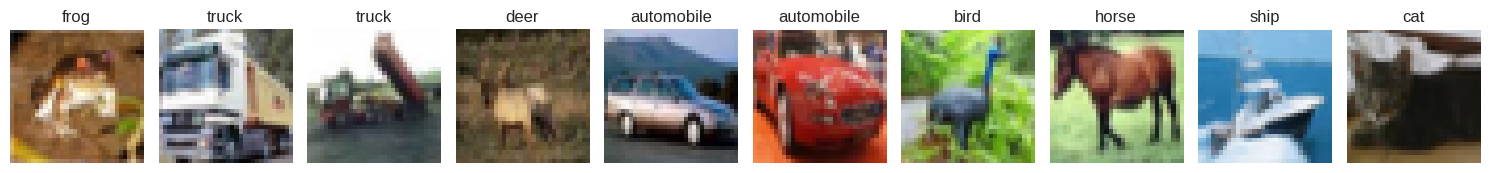

In [11]:
# Display sample images
plot_images(x_train_cifar, y_train_cifar, cifar10_class_names)


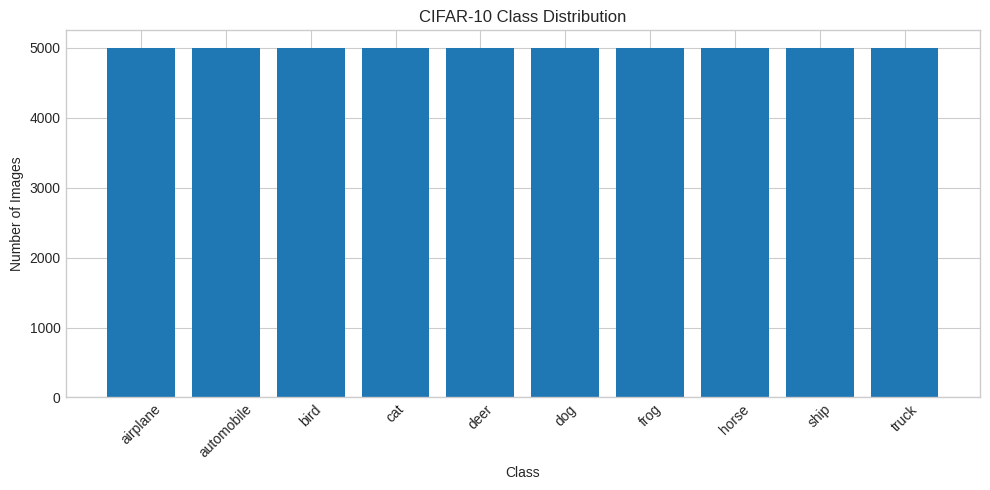

In [12]:
# Show data distribution
plt.figure(figsize=(10, 5))
class_counts = np.bincount(y_train_cifar.flatten())
plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(class_counts)), cifar10_class_names, rotation=45)
plt.title('CIFAR-10 Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [13]:
# Compute and display dataset statistics
def dataset_statistics(x_data, title="Dataset"):
    # Calculate mean and standard deviation per channel
    mean_per_channel = np.mean(x_data, axis=(0, 1, 2))
    std_per_channel = np.std(x_data, axis=(0, 1, 2))

    # Calculate overall brightness
    brightness = np.mean(x_data, axis=3) if x_data.shape[-1] == 3 else x_data.squeeze()
    avg_brightness = np.mean(brightness)

    # Create a figure with histograms
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot histogram of overall pixel values
    axs[0].hist(x_data.flatten(), bins=50, alpha=0.7)
    axs[0].set_title(f'{title} Pixel Value Distribution')
    axs[0].set_xlabel('Normalized Pixel Value')
    axs[0].set_ylabel('Frequency')

    # Plot brightness histogram
    axs[1].hist(brightness.flatten(), bins=50, alpha=0.7)
    axs[1].set_title(f'{title} Brightness Distribution')
    axs[1].set_xlabel('Brightness')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"{title} Statistics:")
    if x_data.shape[-1] == 3:
        print(f"  Mean per channel: R={mean_per_channel[0]:.4f}, G={mean_per_channel[1]:.4f}, B={mean_per_channel[2]:.4f}")
        print(f"  Std per channel: R={std_per_channel[0]:.4f}, G={std_per_channel[1]:.4f}, B={std_per_channel[2]:.4f}")
    else:
        print(f"  Mean: {mean_per_channel.item():.4f}")
        print(f"  Standard deviation: {std_per_channel.item():.4f}")
    print(f"  Average brightness: {avg_brightness:.4f}")
    print(f"  Min value: {np.min(x_data):.4f}")
    print(f"  Max value: {np.max(x_data):.4f}")

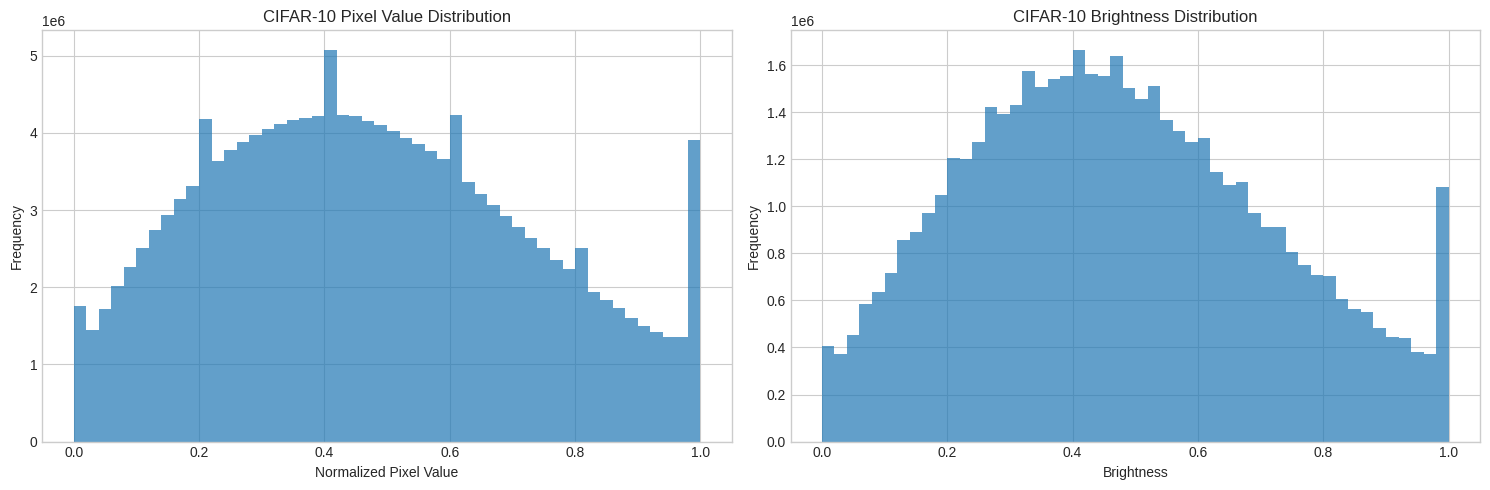

CIFAR-10 Statistics:
  Mean per channel: R=0.4914, G=0.4822, B=0.4465
  Std per channel: R=0.2470, G=0.2435, B=0.2616
  Average brightness: 0.4734
  Min value: 0.0000
  Max value: 1.0000


In [14]:
# Display statistics for CIFAR-10
dataset_statistics(x_train_cifar, "CIFAR-10")

### 2. Model Architecture

Now, let's define our Variational Autoencoder (VAE) architecture.

In [15]:
# Define VAE model
class VAE(keras.Model):
    def __init__(self, input_shape, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape = input_shape

        # Define encoder
        encoder_inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation="relu")(x)

        # Mean and variance for latent distribution
        self.z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

        # Define sampling function as a layer
        self.sampling = layers.Lambda(self._sampling, name="sampling")
        z = self.sampling([self.z_mean, self.z_log_var])

        # Create encoder model
        self.encoder = keras.Model(encoder_inputs, [self.z_mean, self.z_log_var, z], name="encoder")

        # Define decoder
        latent_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
        x = layers.Reshape((4, 4, 128))(x)
        x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

        # Output layer depends on the input shape
        if input_shape[-1] == 3:  # RGB
            decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
        else:  # Grayscale
            decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

        # Create decoder model
        self.decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    def _sampling(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Add KL divergence loss to the model
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)

        return reconstructed

In [16]:
# Define losses and metrics
class VAETrainer:
    def __init__(self, model, learning_rate=1e-4):
        self.model = model
        self.optimizer = Adam(learning_rate=learning_rate)
        self.loss_fn = keras.losses.MeanSquaredError()

        # Metrics
        self.train_loss = keras.metrics.Mean(name='train_loss')
        self.train_reconstruction_loss = keras.metrics.Mean(name='train_reconstruction_loss')
        self.train_kl_loss = keras.metrics.Mean(name='train_kl_loss')

        self.val_loss = keras.metrics.Mean(name='val_loss')
        self.val_reconstruction_loss = keras.metrics.Mean(name='val_reconstruction_loss')
        self.val_kl_loss = keras.metrics.Mean(name='val_kl_loss')

    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Get encoder and decoder output
            z_mean, z_log_var, z = self.model.encoder(x)
            reconstruction = self.model.decoder(z)

            # Compute losses
            reconstruction_loss = self.loss_fn(x, reconstruction) * np.prod(x.shape[1:])
            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients
        grads = tape.gradient(total_loss, self.model.trainable_weights)

        # Apply gradients
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        # Update metrics
        self.train_loss.update_state(total_loss)
        self.train_reconstruction_loss.update_state(reconstruction_loss)
        self.train_kl_loss.update_state(kl_loss)

        return {
            "loss": self.train_loss.result(),
            "reconstruction_loss": self.train_reconstruction_loss.result(),
            "kl_loss": self.train_kl_loss.result()
        }

    @tf.function
    def test_step(self, x):
        # Get encoder and decoder output
        z_mean, z_log_var, z = self.model.encoder(x)
        reconstruction = self.model.decoder(z)

        # Compute losses
        reconstruction_loss = self.loss_fn(x, reconstruction) * np.prod(x.shape[1:])
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        total_loss = reconstruction_loss + kl_loss

        # Update metrics
        self.val_loss.update_state(total_loss)
        self.val_reconstruction_loss.update_state(reconstruction_loss)
        self.val_kl_loss.update_state(kl_loss)

        return {
            "loss": self.val_loss.result(),
            "reconstruction_loss": self.val_reconstruction_loss.result(),
            "kl_loss": self.val_kl_loss.result()
        }

    def reset_metrics(self):
        self.train_loss.reset_state()  # Changed from reset_states() to reset_state()
        self.train_reconstruction_loss.reset_state()  # Changed from reset_states() to reset_state()
        self.train_kl_loss.reset_state()  # Changed from reset_states() to reset_state()
        self.val_loss.reset_state()  # Changed from reset_states() to reset_state()
        self.val_reconstruction_loss.reset_state()  # Changed from reset_states() to reset_state()
        self.val_kl_loss.reset_state()  # Changed from reset_states() to reset_state()


In [17]:
# Display model architecture
def display_model_architecture(model, input_shape):
    """Display model architecture with a summary and diagram."""
    # Create a dummy input for visualization
    dummy_input = tf.keras.Input(shape=input_shape)

    # Display encoder architecture
    print("\nEncoder Architecture:")
    model.encoder.summary()

    # Display decoder architecture
    print("\nDecoder Architecture:")
    model.decoder.summary()

    # Display full model architecture
    print("\nFull VAE Architecture:")
    model(dummy_input)
    model.summary()

In [18]:
# Initialize model for CIFAR-10
latent_dim = 128
cifar_vae = VAE(input_shape=(32, 32, 3), latent_dim=latent_dim)
cifar_trainer = VAETrainer(cifar_vae)

In [19]:
# Display model architecture
display_model_architecture(cifar_vae, (32, 32, 3))


Encoder Architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Lambda)   │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 683,584 (2.61 MB)

 Trainable params: 683,584 (2.61 MB)

 Non-trainable params: 0 (0.00 B)


Decoder Architecture:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,899 (1.93 MB)

 Trainable params: 504,899 (1.93 MB)

 Non-trainable params: 0 (0.00 B)


Full VAE Architecture:


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sampling (Lambda)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ ((None, 128), (None,   │       683,584 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       504,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,188,483 (4.53 MB)

 Trainable params: 1,188,483 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Training Procedure

Now, let's train our VAE model on the CIFAR-10 dataset.

In [20]:
# Define a function for model training
def train_model(model, trainer, x_train, x_val, batch_size=128, epochs=20):
    # Prepare dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices(x_val)
    val_dataset = val_dataset.batch(batch_size)

    # Initialize history
    history = {
        'loss': [],
        'reconstruction_loss': [],
        'kl_loss': [],
        'val_loss': [],
        'val_reconstruction_loss': [],
        'val_kl_loss': []
    }

    # Training loop
    for epoch in range(epochs):
        # Reset metrics
        trainer.reset_metrics()

        # Training step
        start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train on batches
        pbar = tqdm(train_dataset, desc=f"Training")
        for batch in pbar:
            train_metrics = trainer.train_step(batch)
            pbar.set_postfix({
                'loss': f"{train_metrics['loss']:.4f}",
                'recon_loss': f"{train_metrics['reconstruction_loss']:.4f}",
                'kl_loss': f"{train_metrics['kl_loss']:.4f}"
            })

        # Validation step
        pbar = tqdm(val_dataset, desc=f"Validation")
        for batch in pbar:
            val_metrics = trainer.test_step(batch)
            pbar.set_postfix({
                'loss': f"{val_metrics['loss']:.4f}",
                'recon_loss': f"{val_metrics['reconstruction_loss']:.4f}",
                'kl_loss': f"{val_metrics['kl_loss']:.4f}"
            })

        # Display epoch results
        train_loss = trainer.train_loss.result()
        train_reconstruction_loss = trainer.train_reconstruction_loss.result()
        train_kl_loss = trainer.train_kl_loss.result()

        val_loss = trainer.val_loss.result()
        val_reconstruction_loss = trainer.val_reconstruction_loss.result()
        val_kl_loss = trainer.val_kl_loss.result()

        elapsed_time = time.time() - start_time

        print(f"Time taken: {elapsed_time:.2f}s")
        print(f"Training: loss={train_loss:.4f}, reconstruction_loss={train_reconstruction_loss:.4f}, kl_loss={train_kl_loss:.4f}")
        print(f"Validation: loss={val_loss:.4f}, reconstruction_loss={val_reconstruction_loss:.4f}, kl_loss={val_kl_loss:.4f}")

        # Update history
        history['loss'].append(float(train_loss))
        history['reconstruction_loss'].append(float(train_reconstruction_loss))
        history['kl_loss'].append(float(train_kl_loss))
        history['val_loss'].append(float(val_loss))
        history['val_reconstruction_loss'].append(float(val_reconstruction_loss))
        history['val_kl_loss'].append(float(val_kl_loss))

        # Visualize reconstruction at end of each epoch
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            visualize_reconstructions(model, x_test_cifar[:10], epoch+1)

    return history

In [21]:
# Define a function to visualize reconstructions
def visualize_reconstructions(model, test_images, epoch=None):
    # Get reconstructions
    _, _, z = model.encoder(test_images)
    reconstructions = model.decoder(z)

    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")

    if epoch:
        plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()

In [22]:
# Define a function to visualize the learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history['loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history['reconstruction_loss'], label='Training')
    plt.plot(history['val_reconstruction_loss'], label='Validation')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot KL loss
    plt.subplot(1, 3, 3)
    plt.plot(history['kl_loss'], label='Training')
    plt.plot(history['val_kl_loss'], label='Validation')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
# Train the model on CIFAR-10
# For demonstration purposes, we'll use a smaller epoch count.
# Increase for better results.
epochs = 10
batch_size = 128


Epoch 1/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 13.72s
Training: loss=135.5890, reconstruction_loss=134.3374, kl_loss=1.2516
Validation: loss=78.4069, reconstruction_loss=75.5414, kl_loss=2.8655


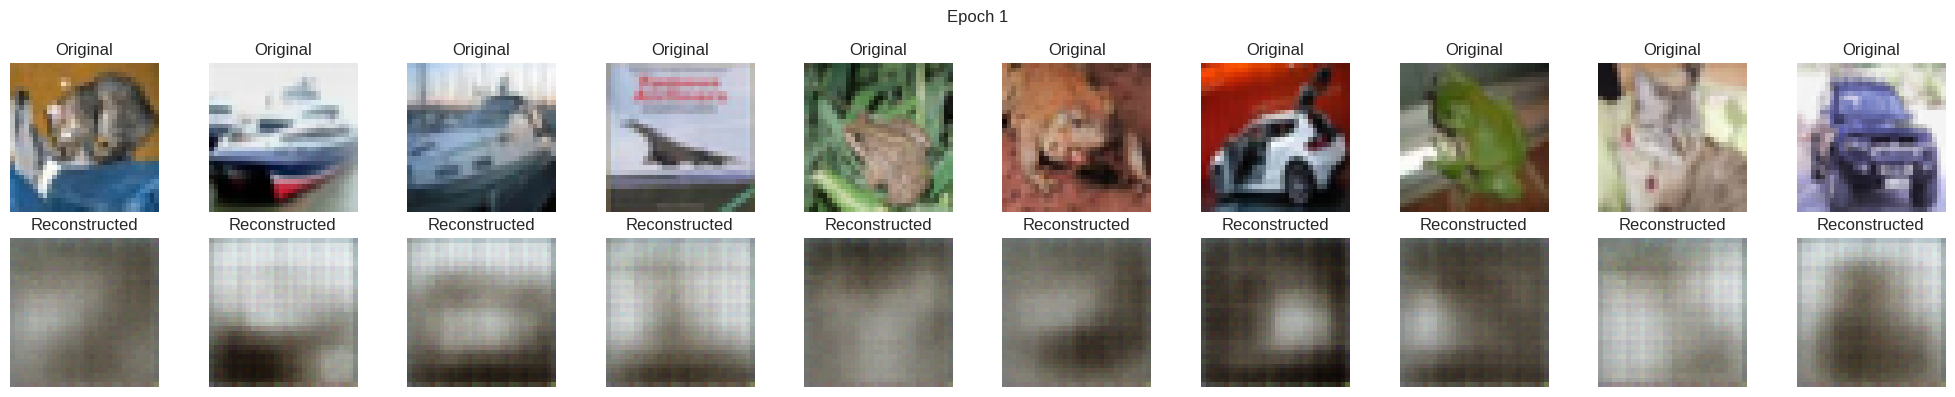


Epoch 2/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 10.89s
Training: loss=69.2937, reconstruction_loss=66.5005, kl_loss=2.7932
Validation: loss=63.6530, reconstruction_loss=60.9420, kl_loss=2.7110

Epoch 3/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 5.68s
Training: loss=60.0737, reconstruction_loss=57.3679, kl_loss=2.7059
Validation: loss=57.4489, reconstruction_loss=54.7552, kl_loss=2.6937

Epoch 4/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 10.89s
Training: loss=55.4632, reconstruction_loss=52.8113, kl_loss=2.6519
Validation: loss=53.9475, reconstruction_loss=51.2914, kl_loss=2.6561

Epoch 5/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 5.89s
Training: loss=51.7098, reconstruction_loss=49.0791, kl_loss=2.6307
Validation: loss=51.6762, reconstruction_loss=49.0126, kl_loss=2.6636


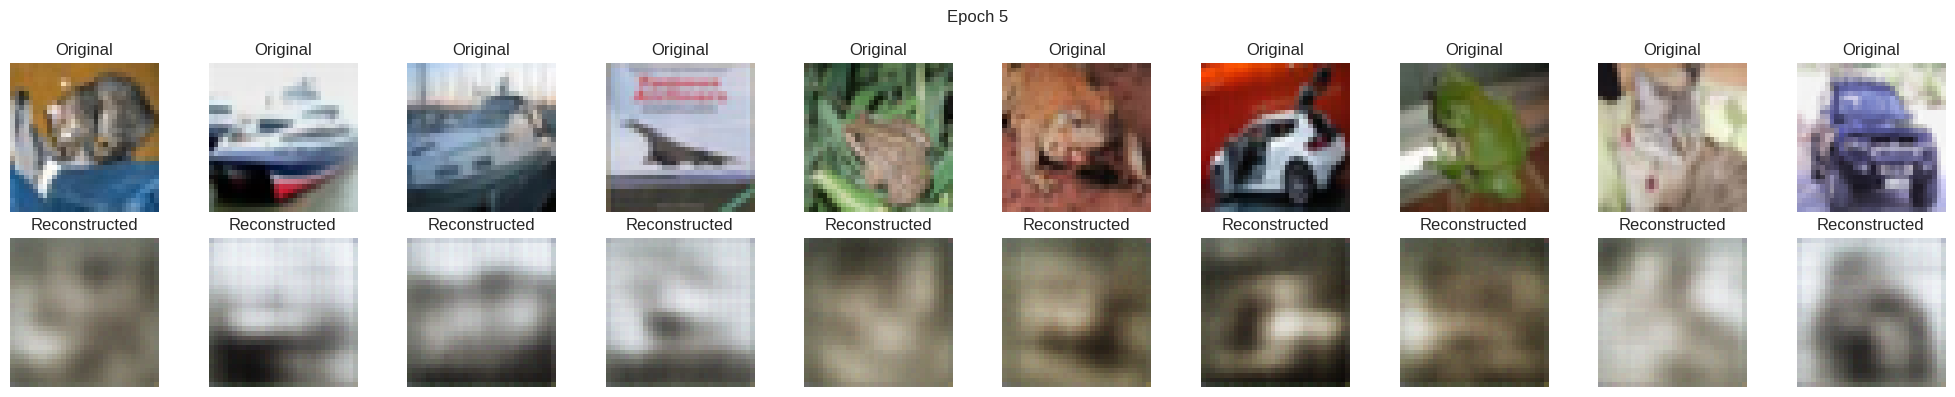


Epoch 6/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 10.88s
Training: loss=46.8858, reconstruction_loss=44.1657, kl_loss=2.7201
Validation: loss=44.6094, reconstruction_loss=41.8296, kl_loss=2.7798

Epoch 7/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 10.74s
Training: loss=43.2114, reconstruction_loss=40.4783, kl_loss=2.7332
Validation: loss=42.6647, reconstruction_loss=40.0097, kl_loss=2.6550

Epoch 8/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 10.70s
Training: loss=41.3292, reconstruction_loss=38.6536, kl_loss=2.6756
Validation: loss=40.6622, reconstruction_loss=37.9886, kl_loss=2.6736

Epoch 9/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 10.67s
Training: loss=39.6562, reconstruction_loss=36.9999, kl_loss=2.6563
Validation: loss=39.0032, reconstruction_loss=36.3547, kl_loss=2.6485

Epoch 10/10


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Time taken: 6.13s
Training: loss=38.1214, reconstruction_loss=35.4683, kl_loss=2.6531
Validation: loss=37.6578, reconstruction_loss=35.0214, kl_loss=2.6364


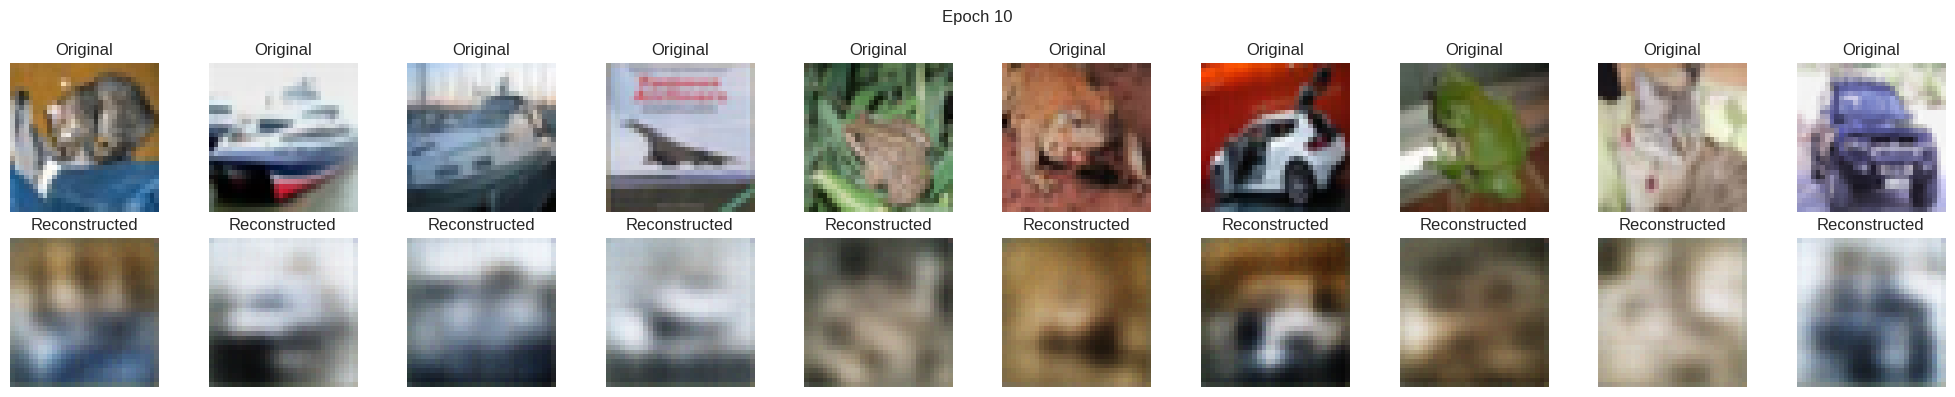

In [24]:
# Split the training data into train and validation
val_split = 0.1
n_val = int(len(x_train_cifar) * val_split)
x_val_cifar = x_train_cifar[:n_val]
x_train_cifar_final = x_train_cifar[n_val:]

history_cifar = train_model(
    cifar_vae,
    cifar_trainer,
    x_train_cifar_final,
    x_val_cifar,
    batch_size=batch_size,
    epochs=epochs
)

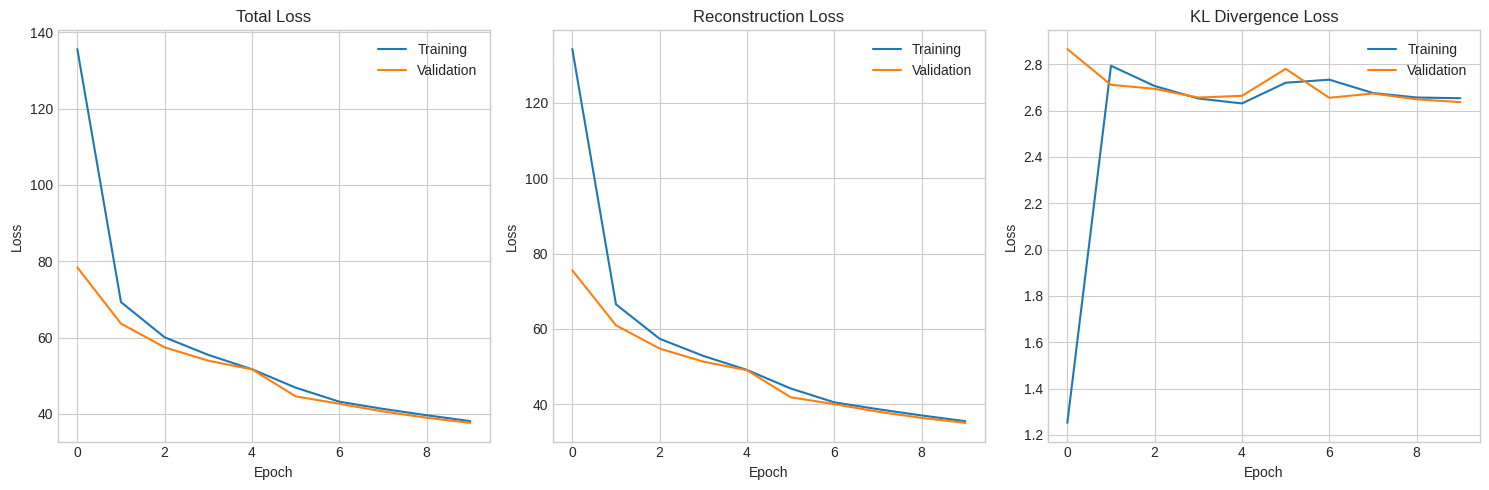

In [25]:
# Plot learning curves
plot_learning_curves(history_cifar)

### 4. Evaluation Metrics and Visualizations

Let's evaluate our trained model on the CIFAR-10 dataset.

In [26]:
# Define functions for evaluation and visualization
def generate_samples(model, n_samples=10):
    """Generate new images from random latent vectors."""
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(n_samples, model.latent_dim))

    # Decode the latent vectors
    generated_images = model.decoder(random_latent_vectors)

    # Display the generated images
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.suptitle('Generated Samples')
    plt.tight_layout()
    plt.show()

    return generated_images

In [27]:
def latent_space_visualization(model, x_test, y_test, class_names, n_samples=1000):
    """Visualize the latent space using t-SNE."""
    # Select a subset of test images
    indices = np.random.choice(len(x_test), n_samples, replace=False)
    x_subset = x_test[indices]
    y_subset = y_test[indices]

    # Encode images to get the mean latent vector
    z_mean, _, _ = model.encoder(x_subset)

    # Use t-SNE to reduce dimensionality to 2D
    print("Applying t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    z_tsne = tsne.fit_transform(z_mean)

    # Create scatter plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_subset, cmap='tab10')
    plt.colorbar(scatter, ticks=range(len(class_names)), label='Class')
    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Add legend
    handles, labels = scatter.legend_elements()
    plt.legend(handles, class_names, title="Classes")

    plt.tight_layout()
    plt.show()

    # Compute silhouette score to evaluate cluster separation
    if len(np.unique(y_subset)) > 1:
        silhouette = silhouette_score(z_tsne, y_subset.flatten())
        print(f"Silhouette Score: {silhouette:.4f}")
        return silhouette
    return None

In [28]:
def latent_space_interpolation(model, x_test, n_samples=10):
    """Interpolate between two images in the latent space."""
    # Select two random images
    idx1, idx2 = np.random.choice(len(x_test), 2, replace=False)
    img1, img2 = x_test[idx1], x_test[idx2]

    # Display original images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('Start Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title('End Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Encode both images
    z_mean1, _, _ = model.encoder(np.expand_dims(img1, axis=0))
    z_mean2, _, _ = model.encoder(np.expand_dims(img2, axis=0))

    # Create interpolation steps
    alphas = np.linspace(0, 1, n_samples)
    z_interp = np.zeros((n_samples, model.latent_dim))

    for i, alpha in enumerate(alphas):
        z_interp[i] = alpha * z_mean2[0] + (1 - alpha) * z_mean1[0]

    # Generate images from the interpolated latent vectors
    generated_images = model.decoder(z_interp)

    # Display the interpolation
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_images[i])
        plt.title(f"{alphas[i]:.2f}")
        plt.axis('off')

    plt.suptitle('Latent Space Interpolation')
    plt.tight_layout()
    plt.show()

    return generated_images


In [29]:
def evaluate_model(model, x_test, y_test, class_names):
    """Comprehensive evaluation of the VAE model."""
    print("Model Evaluation:")

    # 1. Generate new samples
    print("\n1. Generating samples from random latent vectors...")
    generated_samples = generate_samples(model, n_samples=10)

    # 2. Visualize reconstructions
    print("\n2. Visualizing reconstructions...")
    visualize_reconstructions(model, x_test[:10])

    # 3. Visualize latent space
    print("\n3. Visualizing latent space...")
    silhouette = latent_space_visualization(model, x_test, y_test, class_names, n_samples=1000)

    # 4. Interpolation in latent space
    print("\n4. Performing latent space interpolation...")
    interpolated_samples = latent_space_interpolation(model, x_test, n_samples=10)

    # 5. Conditional generation based on class (if applicable)
    print("\n5. Conditional generation based on class...")
    class_samples = {}
    for class_idx in range(len(class_names)):
        # Get images of the specific class
        class_indices = np.where(y_test.flatten() == class_idx)[0]
        if len(class_indices) > 0:
            # Take 5 random samples from this class
            sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)

            # Encode the images
            sample_images = x_test[sample_indices]
            z_mean, z_log_var, _ = model.encoder(sample_images)

            # Average the latent vectors
            avg_z = tf.reduce_mean(z_mean, axis=0, keepdims=True)

            # Generate an image from the average latent vector
            class_samples[class_idx] = model.decoder(avg_z)[0]

    # Display class-conditional samples
    plt.figure(figsize=(15, 3))
    for i, (class_idx, img) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), i + 1)
        plt.imshow(img)
        plt.title(f"{class_names[class_idx]}")
        plt.axis('off')

    plt.suptitle('Class-Conditional Generated Samples')
    plt.tight_layout()
    plt.show()

    # 6. Analyze reconstruction error by class
    print("\n6. Analyzing reconstruction error by class...")
    class_recon_errors = {}

    for class_idx in range(len(class_names)):
        # Get images of the specific class
        class_indices = np.where(y_test.flatten() == class_idx)[0]
        if len(class_indices) > 0:
            # Take random samples from this class
            sample_indices = np.random.choice(class_indices, min(100, len(class_indices)), replace=False)

            # Get the images
            sample_images = x_test[sample_indices]

            # Reconstruct the images
            _, _, z = model.encoder(sample_images)
            reconstructions = model.decoder(z)

            # Calculate reconstruction error
            mse = tf.reduce_mean(tf.square(sample_images - reconstructions), axis=(1, 2, 3))
            class_recon_errors[class_idx] = np.mean(mse)

    # Plot reconstruction errors by class
    plt.figure(figsize=(10, 5))
    classes, errors = zip(*sorted(class_recon_errors.items()))
    plt.bar(classes, errors)
    plt.xticks(classes, [class_names[c] for c in classes], rotation=45)
    plt.title('Reconstruction Error by Class')
    plt.xlabel('Class')
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()

    return silhouette, class_recon_errors


Model Evaluation:

1. Generating samples from random latent vectors...


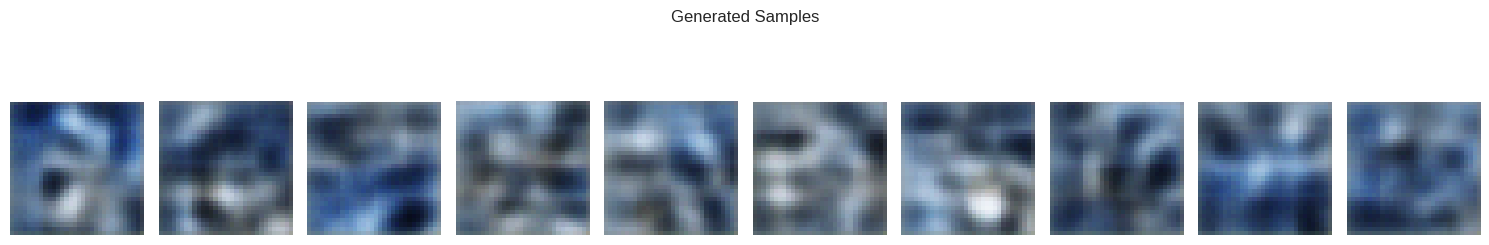


2. Visualizing reconstructions...


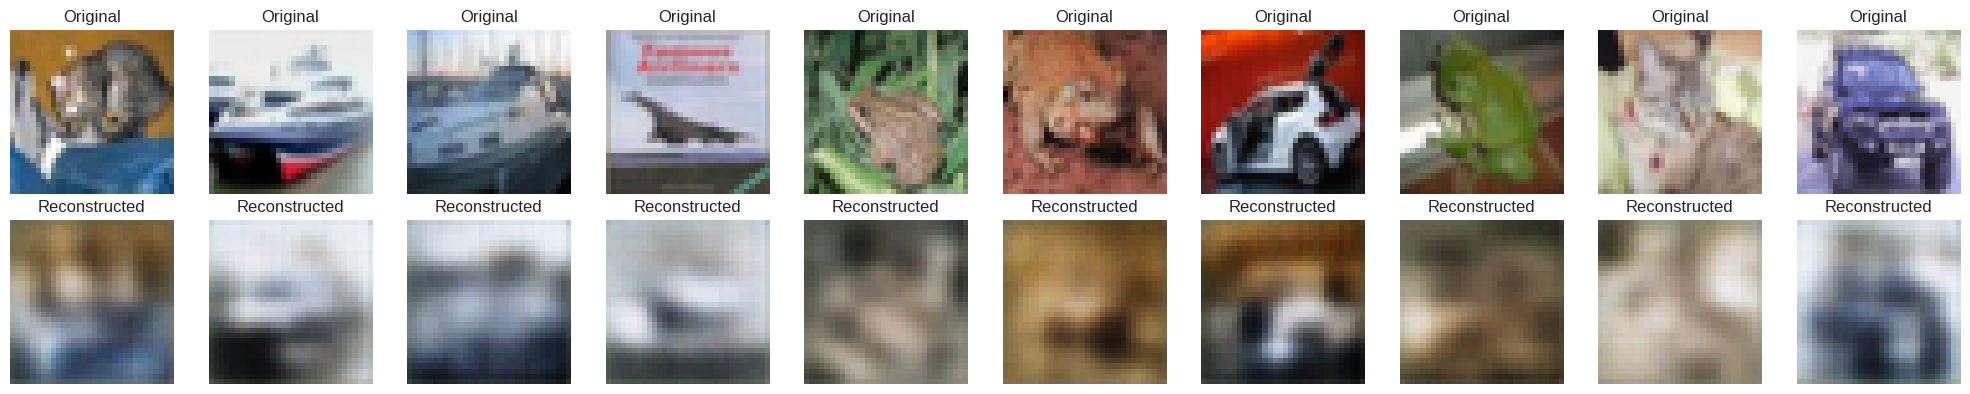


3. Visualizing latent space...
Applying t-SNE dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


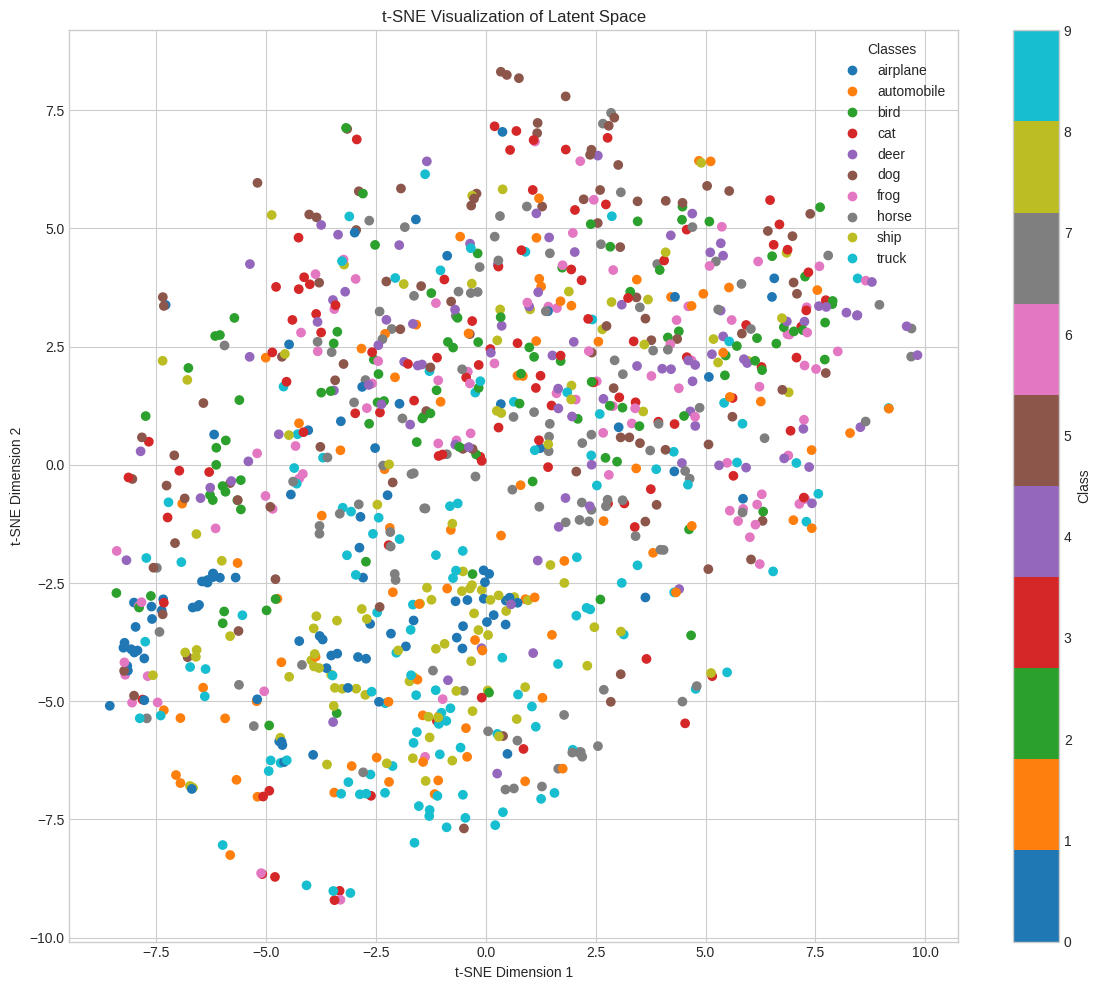

Silhouette Score: -0.1311

4. Performing latent space interpolation...


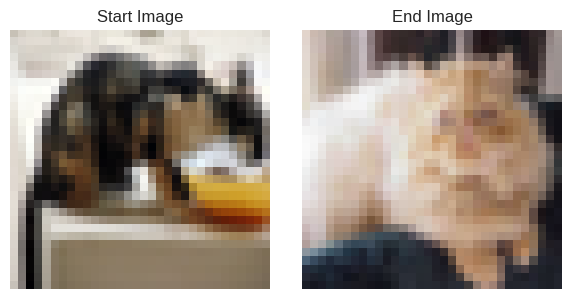

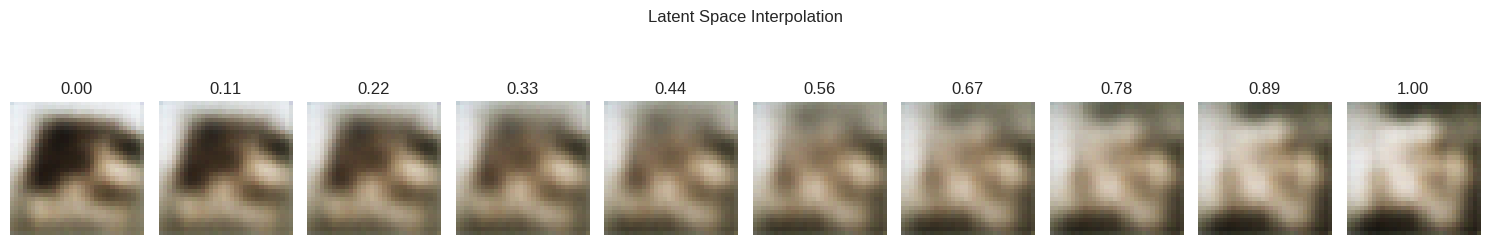


5. Conditional generation based on class...


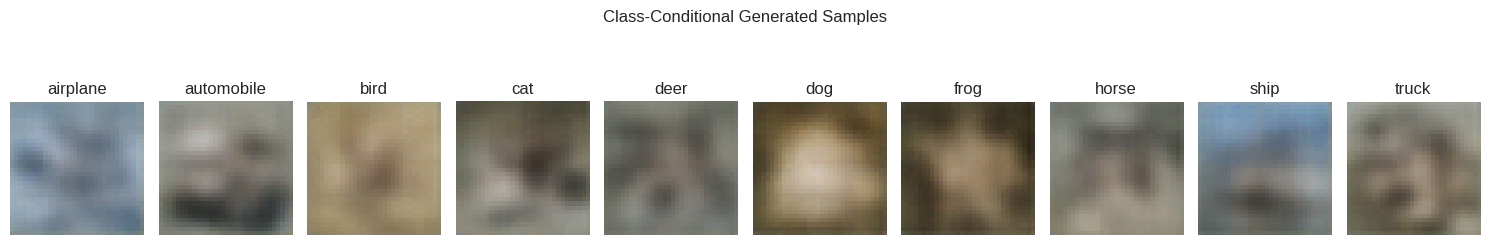


6. Analyzing reconstruction error by class...


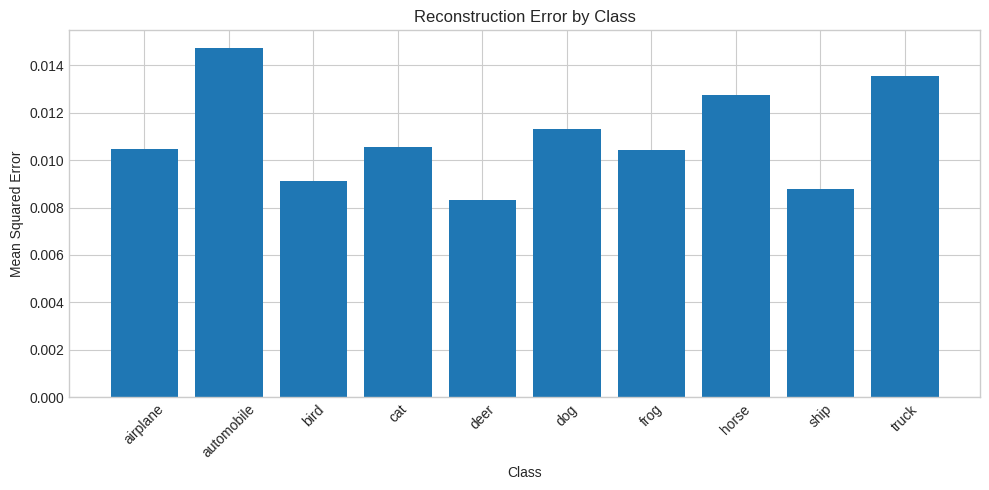

In [30]:
# Evaluate the model on CIFAR-10
silhouette_cifar, recon_errors_cifar = evaluate_model(
    cifar_vae,
    x_test_cifar,
    y_test_cifar,
    cifar10_class_names
)

### 5. Discussion of Results and Limitations

Let's discuss the results of our CIFAR-10 VAE and analyze its limitations.


In [31]:
# Create a function for discussing results
def discuss_results(silhouette, recon_errors, class_names):
    """Analyze and discuss the model results."""
    print("## Discussion of Results and Limitations")
    print("\n### Key Findings:")

    # Analyze reconstruction quality
    avg_recon_error = np.mean(list(recon_errors.values()))
    print(f"\n1. Overall reconstruction quality:")
    print(f"   - Average reconstruction error: {avg_recon_error:.4f}")

    # Find best and worst reconstructed classes
    best_class = min(recon_errors, key=recon_errors.get)
    worst_class = max(recon_errors, key=recon_errors.get)

    print(f"   - Best reconstructed class: {class_names[best_class]} (Error: {recon_errors[best_class]:.4f})")
    print(f"   - Worst reconstructed class: {class_names[worst_class]} (Error: {recon_errors[worst_class]:.4f})")

    # Analyze latent space organization
    if silhouette is not None:
        print(f"\n2. Latent space organization:")
        print(f"   - Silhouette score: {silhouette:.4f}")

        if silhouette > 0.3:
            quality = "well-separated"
        elif silhouette > 0.1:
            quality = "somewhat separated"
        else:
            quality = "poorly separated"

        print(f"   - Classes are {quality} in the latent space")

    # Discuss limitations
    print("\n### Limitations:")

    # Common VAE limitations
    print("\n1. Blurriness in reconstructions:")
    print("   - VAEs are known to produce blurry reconstructions due to the probabilistic nature of the latent space")
    print("   - This effect is particularly noticeable in complex, detailed images")

    print("\n2. Limited expressiveness of the Gaussian latent space:")
    print("   - The normal distribution assumption in the latent space may limit the model's ability to capture complex data distributions")
    print("   - This can lead to mode collapse or inability to generate certain types of samples")

    print("\n3. Training stability:")
    print("   - Balancing the reconstruction loss and KL divergence loss can be challenging")
    print("   - The model may prioritize one aspect over the other, leading to suboptimal results")

    # Dataset-specific limitations
    print(f"\n4. Dataset-specific challenges:")
    print(f"   - Complex classes like '{class_names[worst_class]}' have higher reconstruction errors")
    print(f"   - This suggests the model struggles with certain visual features or variations within these classes")

    # Potential improvements
    print("\n### Potential Improvements:")
    print("\n1. Architecture enhancements:")
    print("   - Deeper or wider networks with more capacity")
    print("   - Adding residual connections to improve gradient flow")
    print("   - Using more sophisticated building blocks (e.g., attention mechanisms)")

    print("\n2. Latent space modifications:")
    print("   - Using a more flexible posterior distribution (e.g., normalizing flows)")
    print("   - Increasing the dimensionality of the latent space")
    print("   - Implementing a hierarchical latent structure")

    print("\n3. Training strategies:")
    print("   - Annealing the KL divergence term during training")
    print("   - Using cyclical learning rates")
    print("   - Implementing a perceptual loss instead of pixel-wise MSE")

    # Create a visual summary
    plt.figure(figsize=(12, 8))

    # Plot reconstruction errors by class
    plt.subplot(2, 1, 1)
    classes, errors = zip(*sorted(recon_errors.items()))
    bars = plt.bar(classes, errors)
    plt.xticks(classes, [class_names[c] for c in classes], rotation=45)
    plt.title('Reconstruction Error by Class')
    plt.xlabel('Class')
    plt.ylabel('Mean Squared Error')

    # Highlight best and worst classes
    bars[best_class].set_color('green')
    bars[worst_class].set_color('red')

    # Add annotations
    plt.annotate('Best', xy=(best_class, recon_errors[best_class]),
                 xytext=(best_class, recon_errors[best_class] + 0.01),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.annotate('Worst', xy=(worst_class, recon_errors[worst_class]),
                 xytext=(worst_class, recon_errors[worst_class] + 0.01),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # Plot radar chart of errors
    plt.subplot(2, 1, 2)

    # Prepare data for radar chart
    categories = [class_names[c] for c in sorted(recon_errors.keys())]
    values = [recon_errors[c] for c in sorted(recon_errors.keys())]

    # Number of variables
    N = len(categories)

    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Values for the first axis need to be repeated
    values += values[:1]

    # Draw the plot
    ax = plt.subplot(2, 1, 2, polar=True)

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=8)

    # Draw the outline of our data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, alpha=0.1)

    # Add title
    plt.title('Reconstruction Error Profile')

    plt.tight_layout()
    plt.show()

## Discussion of Results and Limitations

### Key Findings:

1. Overall reconstruction quality:
   - Average reconstruction error: 0.0110
   - Best reconstructed class: deer (Error: 0.0083)
   - Worst reconstructed class: automobile (Error: 0.0147)

2. Latent space organization:
   - Silhouette score: -0.1311
   - Classes are poorly separated in the latent space

### Limitations:

1. Blurriness in reconstructions:
   - VAEs are known to produce blurry reconstructions due to the probabilistic nature of the latent space
   - This effect is particularly noticeable in complex, detailed images

2. Limited expressiveness of the Gaussian latent space:
   - The normal distribution assumption in the latent space may limit the model's ability to capture complex data distributions
   - This can lead to mode collapse or inability to generate certain types of samples

3. Training stability:
   - Balancing the reconstruction loss and KL divergence loss can be challenging
   - The model may prioritiz

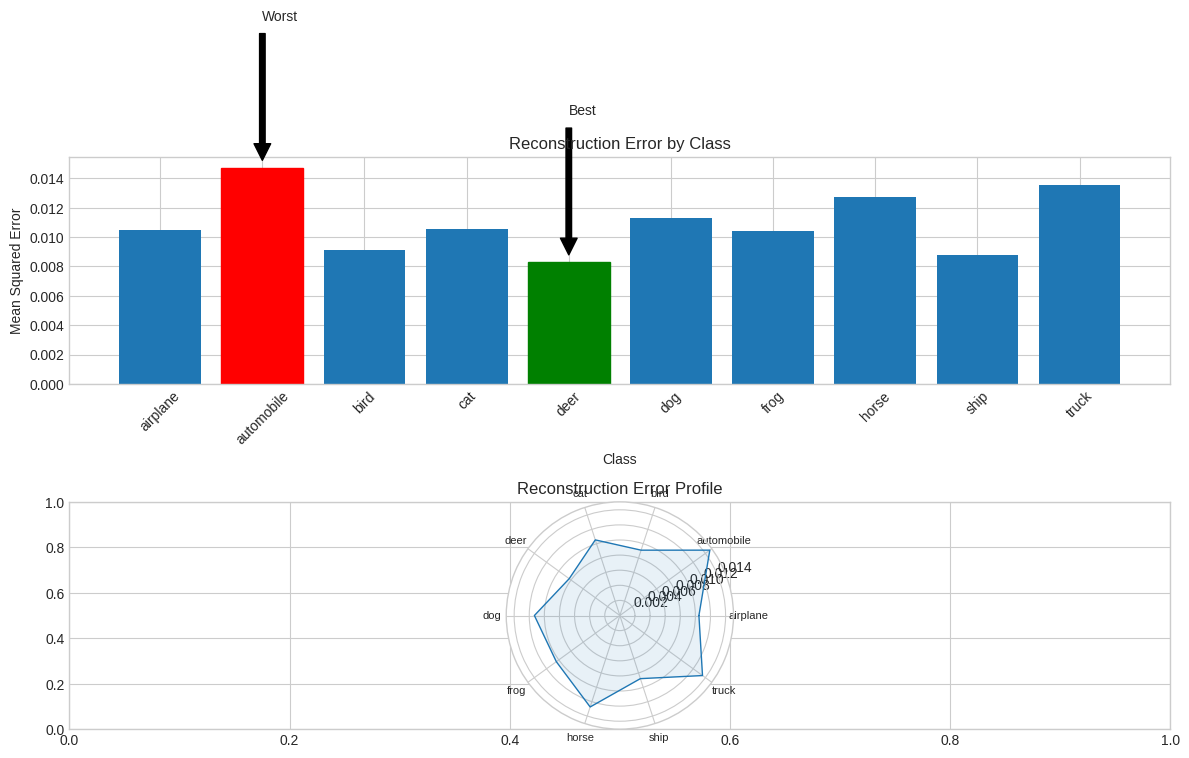

In [32]:
# Discuss the results for CIFAR-10
discuss_results(silhouette_cifar, recon_errors_cifar, cifar10_class_names)

## Second Worked Example: Fashion-MNIST Dataset

Now, let's implement the same VAE approach on our second dataset, Fashion-MNIST, and compare the results.

### 1. Data Loading and Preprocessing

In [33]:
# Load Fashion-MNIST dataset
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
# Print dataset information
print(f"Fashion-MNIST Training set shape: {x_train_fashion.shape}")
print(f"Fashion-MNIST Test set shape: {x_test_fashion.shape}")

Fashion-MNIST Training set shape: (60000, 28, 28)
Fashion-MNIST Test set shape: (10000, 28, 28)


In [35]:
# Reshape to add channel dimension and normalize
x_train_fashion = x_train_fashion.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_fashion = x_test_fashion.reshape(-1, 28, 28, 1).astype('float32') / 255.0


In [36]:
# Define class names for Fashion-MNIST
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [37]:
# Visualize sample images from Fashion-MNIST
def plot_grayscale_images(images, labels=None, class_names=None, n_images=10, figsize=(15, 3)):
    plt.figure(figsize=figsize)
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if labels is not None and class_names is not None:
            plt.title(class_names[labels[i]])
    plt.tight_layout()
    plt.show()

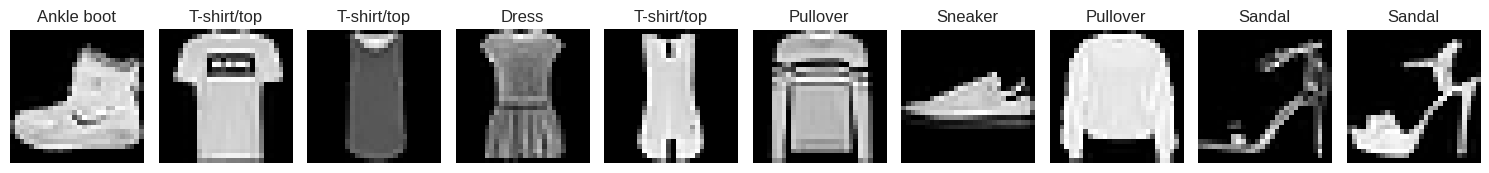

In [38]:
# Display sample images
plot_grayscale_images(x_train_fashion, y_train_fashion, fashion_class_names)

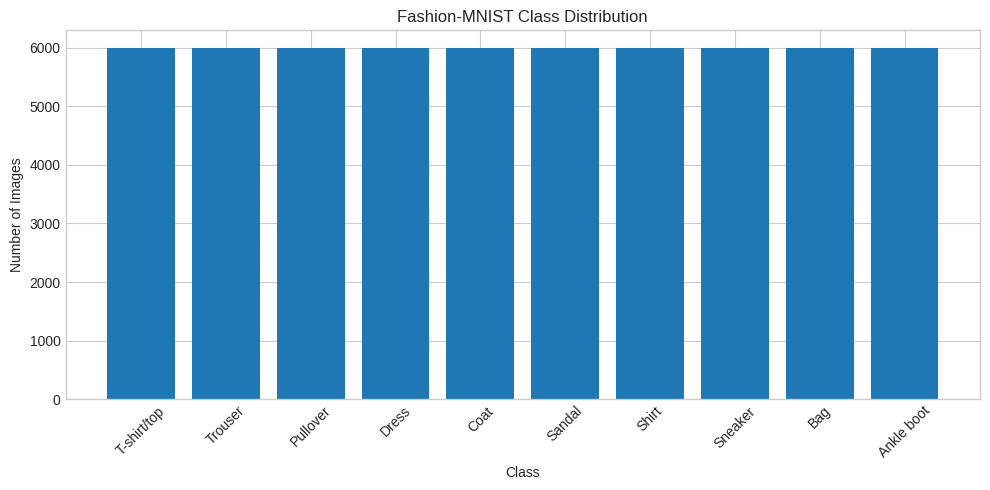

In [39]:
# Show data distribution
plt.figure(figsize=(10, 5))
class_counts = np.bincount(y_train_fashion)
plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(class_counts)), fashion_class_names, rotation=45)
plt.title('Fashion-MNIST Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

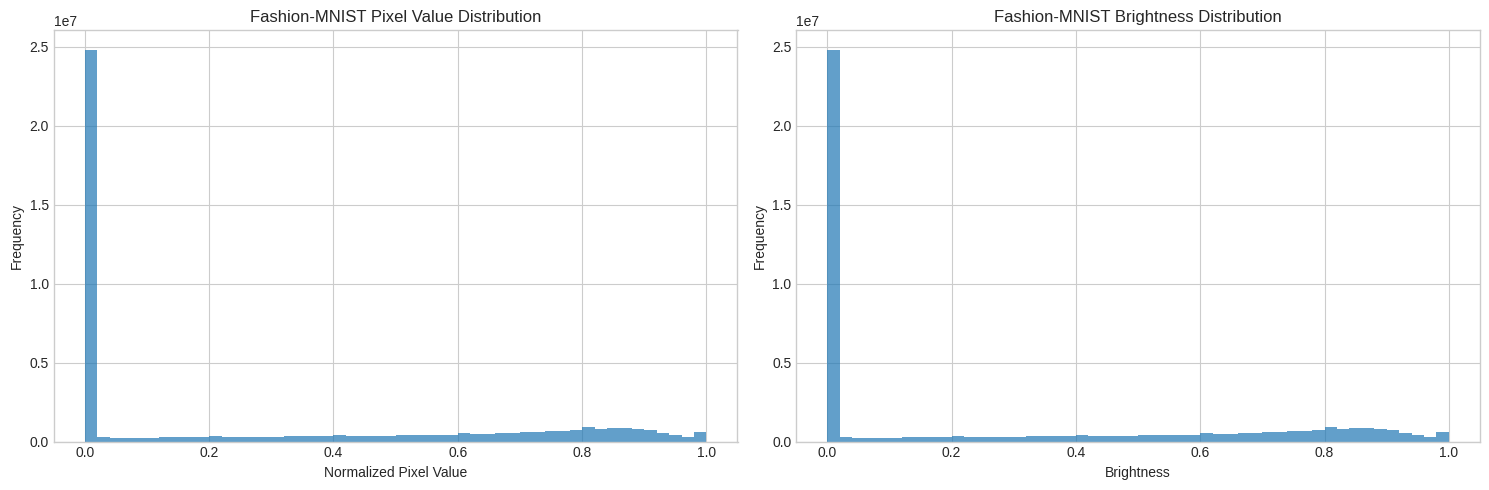

Fashion-MNIST Statistics:
  Mean: 0.2860
  Standard deviation: 0.3530
  Average brightness: 0.2860
  Min value: 0.0000
  Max value: 1.0000


In [40]:
# Compute and display dataset statistics
dataset_statistics(x_train_fashion, "Fashion-MNIST")

In [41]:
# Compare the two datasets
print("\n## Comparison between CIFAR-10 and Fashion-MNIST datasets:")
print(f"CIFAR-10: {x_train_cifar.shape[0]} training examples, {x_test_cifar.shape[0]} test examples")
print(f"Fashion-MNIST: {x_train_fashion.shape[0]} training examples, {x_test_fashion.shape[0]} test examples")
print(f"CIFAR-10 image dimensions: {x_train_cifar.shape[1:]} (RGB)")
print(f"Fashion-MNIST image dimensions: {x_train_fashion.shape[1:]} (Grayscale)")


## Comparison between CIFAR-10 and Fashion-MNIST datasets:
CIFAR-10: 50000 training examples, 10000 test examples
Fashion-MNIST: 60000 training examples, 10000 test examples
CIFAR-10 image dimensions: (32, 32, 3) (RGB)
Fashion-MNIST image dimensions: (28, 28, 1) (Grayscale)


### 2. Model Architecture

Let's initialize our VAE model for the Fashion-MNIST dataset.

In [42]:
# Initialize model for Fashion-MNIST
fashion_vae = VAE(input_shape=(32, 32, 1), latent_dim=latent_dim)
fashion_trainer = VAETrainer(fashion_vae)

In [43]:
# Display model architecture
display_model_architecture(fashion_vae, (32, 32, 1))


Encoder Architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     32,896 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     32,896 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Lambda)   │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 683,008 (2.61 MB)

 Trainable params: 683,008 (2.61 MB)

 Non-trainable params: 0 (0.00 B)


Decoder Architecture:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,321 (1.92 MB)

 Trainable params: 504,321 (1.92 MB)

 Non-trainable params: 0 (0.00 B)


Full VAE Architecture:


Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sampling (Lambda)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ ((None, 128), (None,   │       683,008 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 1)      │       504,321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,329 (4.53 MB)

 Trainable params: 1,187,329 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Resize Fashion-MNIST to 32x32 to match CIFAR-10 if needed

from tensorflow.keras.preprocessing.image import smart_resize

# Ensure x_train_fashion and x_test_fashion have the correct shape
# x_train_fashion = x_train_fashion.reshape(-1, 32, 32, 1) # Add channel dimension
# x_test_fashion = x_test_fashion.reshape(-1, 32, 32, 1)   # Add channel dimension
# The above lines are incorrect, as they attempt to reshape the entire array
# instead of individual images. We'll use smart_resize instead.


# Resize Fashion-MNIST to match CIFAR-10 dimensions
x_train_fashion_resized = np.zeros((len(x_train_fashion), 32, 32, 1))
x_test_fashion_resized = np.zeros((len(x_test_fashion), 32, 32, 1))

# Correct the loop to store resized images in the correct arrays
for i in range(len(x_train_fashion)):
    x_train_fashion_resized[i] = smart_resize(x_train_fashion[i], (32, 32))

for i in range(len(x_test_fashion)):
    x_test_fashion_resized[i] = smart_resize(x_test_fashion[i], (32, 32))

# Use resized images instead
x_train_fashion = x_train_fashion_resized
x_test_fashion = x_test_fashion_resized

# Initialize model for resized Fashion-MNIST
fashion_vae = VAE(input_shape=(32, 32, 1), latent_dim=latent_dim)
fashion_trainer = VAETrainer(fashion_vae)

### 3. Training Procedure

Now, let's train our VAE model on the Fashion-MNIST dataset.

In [46]:
# Train the model on Fashion-MNIST
# Split the training data into train and validation
n_val = int(len(x_train_fashion) * val_split)
x_val_fashion = x_train_fashion[:n_val]
x_train_fashion_final = x_train_fashion[n_val:]

In [47]:
# Visualize Fashion-MNIST reconstructions
def visualize_fashion_reconstructions(model, test_images, epoch=None):
    # Get reconstructions
    _, _, z = model.encoder(test_images)
    reconstructions = model.decoder(z)

    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_images[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(tf.reshape(reconstructions[i], (32, 32)), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")

    if epoch:
        plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()

In [48]:
# Define a custom training function for Fashion-MNIST
def train_fashion_model(model, trainer, x_train, x_val, batch_size=128, epochs=20):
    # Prepare dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices(x_val)
    val_dataset = val_dataset.batch(batch_size)

    # Initialize history
    history = {
        'loss': [],
        'reconstruction_loss': [],
        'kl_loss': [],
        'val_loss': [],
        'val_reconstruction_loss': [],
        'val_kl_loss': []
    }

    # Training loop
    for epoch in range(epochs):
        # Reset metrics
        trainer.reset_metrics()

        # Training step
        start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train on batches
        pbar = tqdm(train_dataset, desc=f"Training")
        for batch in pbar:
            train_metrics = trainer.train_step(batch)
            pbar.set_postfix({
                'loss': f"{train_metrics['loss']:.4f}",
                'recon_loss': f"{train_metrics['reconstruction_loss']:.4f}",
                'kl_loss': f"{train_metrics['kl_loss']:.4f}"
            })

        # Validation step
        pbar = tqdm(val_dataset, desc=f"Validation")
        for batch in pbar:
            val_metrics = trainer.test_step(batch)
            pbar.set_postfix({
                'loss': f"{val_metrics['loss']:.4f}",
                'recon_loss': f"{val_metrics['reconstruction_loss']:.4f}",
                'kl_loss': f"{val_metrics['kl_loss']:.4f}"
            })

        # Display epoch results
        train_loss = trainer.train_loss.result()
        train_reconstruction_loss = trainer.train_reconstruction_loss.result()
        train_kl_loss = trainer.train_kl_loss.result()

        val_loss = trainer.val_loss.result()
        val_reconstruction_loss = trainer.val_reconstruction_loss.result()
        val_kl_loss = trainer.val_kl_loss.result()

        elapsed_time = time.time() - start_time

        print(f"Time taken: {elapsed_time:.2f}s")
        print(f"Training: loss={train_loss:.4f}, reconstruction_loss={train_reconstruction_loss:.4f}, kl_loss={train_kl_loss:.4f}")
        print(f"Validation: loss={val_loss:.4f}, reconstruction_loss={val_reconstruction_loss:.4f}, kl_loss={val_kl_loss:.4f}")

        # Update history
        history['loss'].append(float(train_loss))
        history['reconstruction_loss'].append(float(train_reconstruction_loss))
        history['kl_loss'].append(float(train_kl_loss))
        history['val_loss'].append(float(val_loss))
        history['val_reconstruction_loss'].append(float(val_reconstruction_loss))
        history['val_kl_loss'].append(float(val_kl_loss))

        # Visualize reconstruction at end of each epoch
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            visualize_fashion_reconstructions(model, x_test_fashion[:10], epoch+1)

    return history


Epoch 1/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 11.91s
Training: loss=58.5756, reconstruction_loss=57.1481, kl_loss=1.4275
Validation: loss=20.3424, reconstruction_loss=18.5858, kl_loss=1.7566


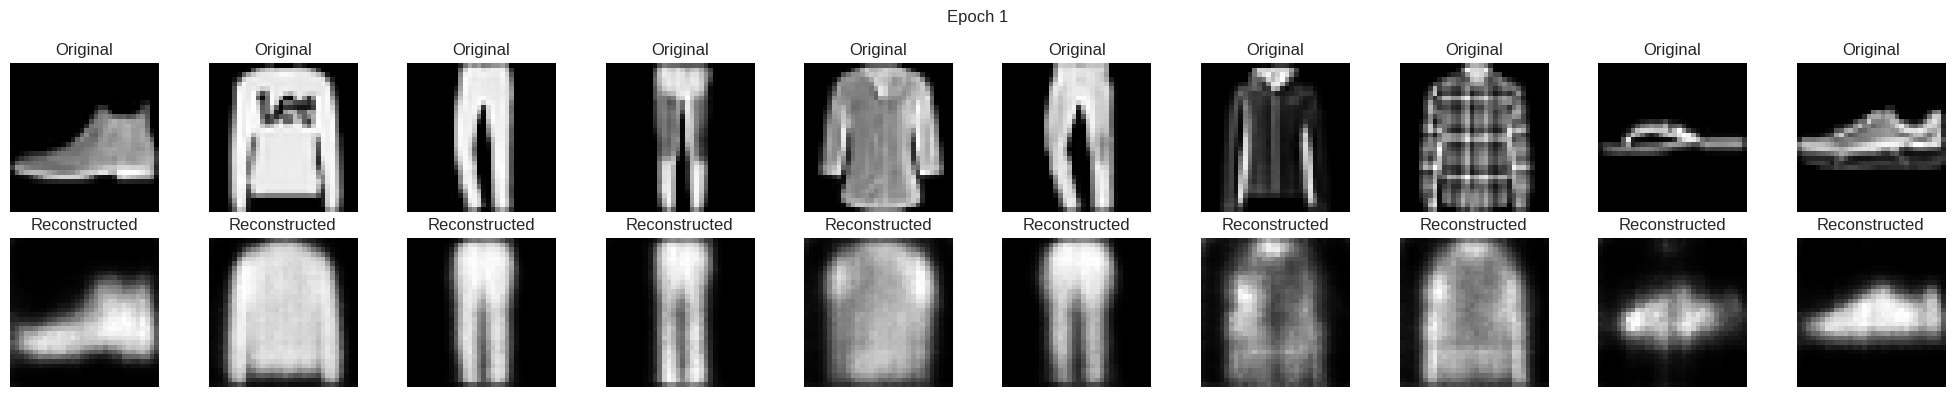


Epoch 2/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 7.04s
Training: loss=17.1251, reconstruction_loss=15.4078, kl_loss=1.7173
Validation: loss=14.8231, reconstruction_loss=13.0947, kl_loss=1.7284

Epoch 3/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 10.72s
Training: loss=13.6245, reconstruction_loss=11.9033, kl_loss=1.7212
Validation: loss=12.7090, reconstruction_loss=10.9888, kl_loss=1.7202

Epoch 4/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 6.92s
Training: loss=12.0054, reconstruction_loss=10.2985, kl_loss=1.7069
Validation: loss=11.4054, reconstruction_loss=9.7176, kl_loss=1.6877

Epoch 5/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 10.74s
Training: loss=10.9372, reconstruction_loss=9.2456, kl_loss=1.6916
Validation: loss=10.6331, reconstruction_loss=8.9361, kl_loss=1.6970


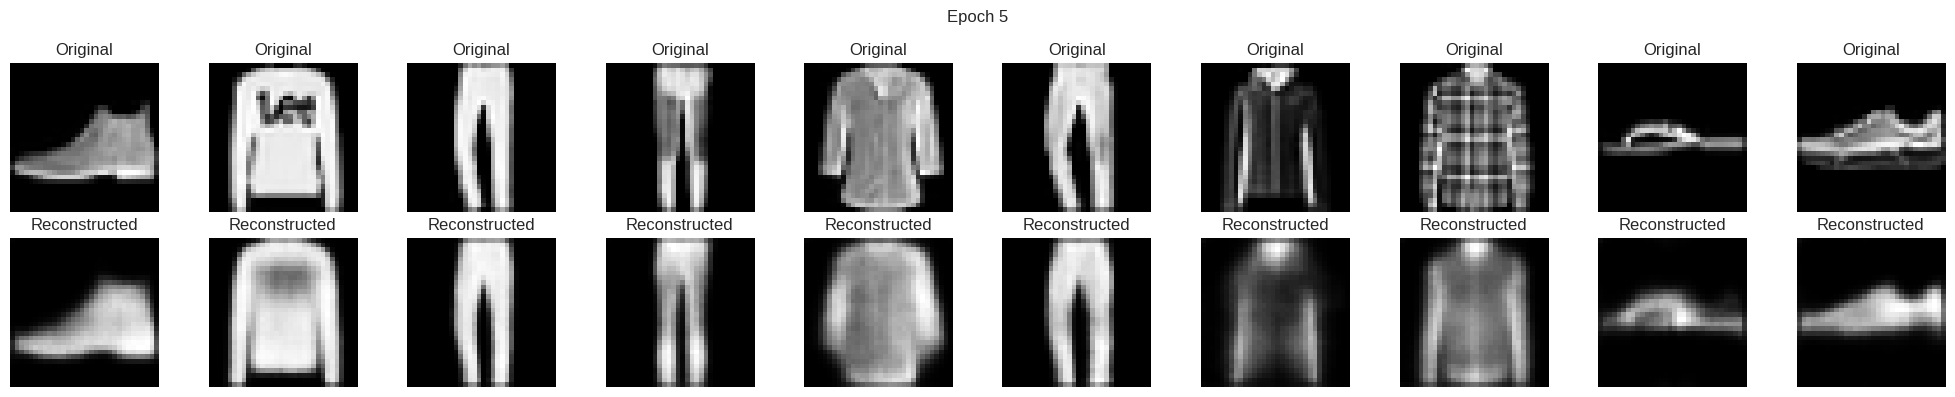


Epoch 6/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 7.08s
Training: loss=10.1689, reconstruction_loss=8.4923, kl_loss=1.6766
Validation: loss=9.8339, reconstruction_loss=8.1632, kl_loss=1.6707

Epoch 7/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 10.72s
Training: loss=9.5895, reconstruction_loss=7.9285, kl_loss=1.6610
Validation: loss=9.3827, reconstruction_loss=7.7261, kl_loss=1.6566

Epoch 8/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 6.84s
Training: loss=9.1346, reconstruction_loss=7.4865, kl_loss=1.6481
Validation: loss=8.9071, reconstruction_loss=7.2712, kl_loss=1.6359

Epoch 9/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 10.70s
Training: loss=8.7517, reconstruction_loss=7.1193, kl_loss=1.6323
Validation: loss=8.5897, reconstruction_loss=6.9564, kl_loss=1.6333

Epoch 10/10


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Time taken: 10.88s
Training: loss=8.4189, reconstruction_loss=6.7984, kl_loss=1.6205
Validation: loss=8.2601, reconstruction_loss=6.6487, kl_loss=1.6114


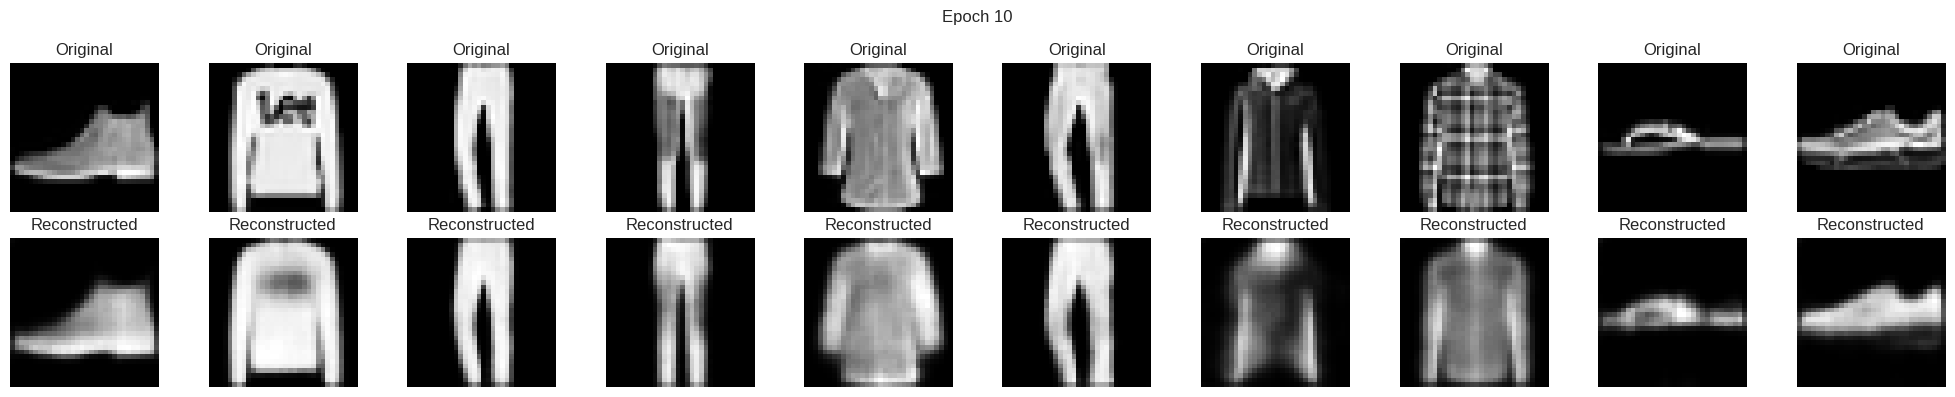

In [49]:
# Train the model on Fashion-MNIST
history_fashion = train_fashion_model(
    fashion_vae,
    fashion_trainer,
    x_train_fashion_final,
    x_val_fashion,
    batch_size=batch_size,
    epochs=epochs
)

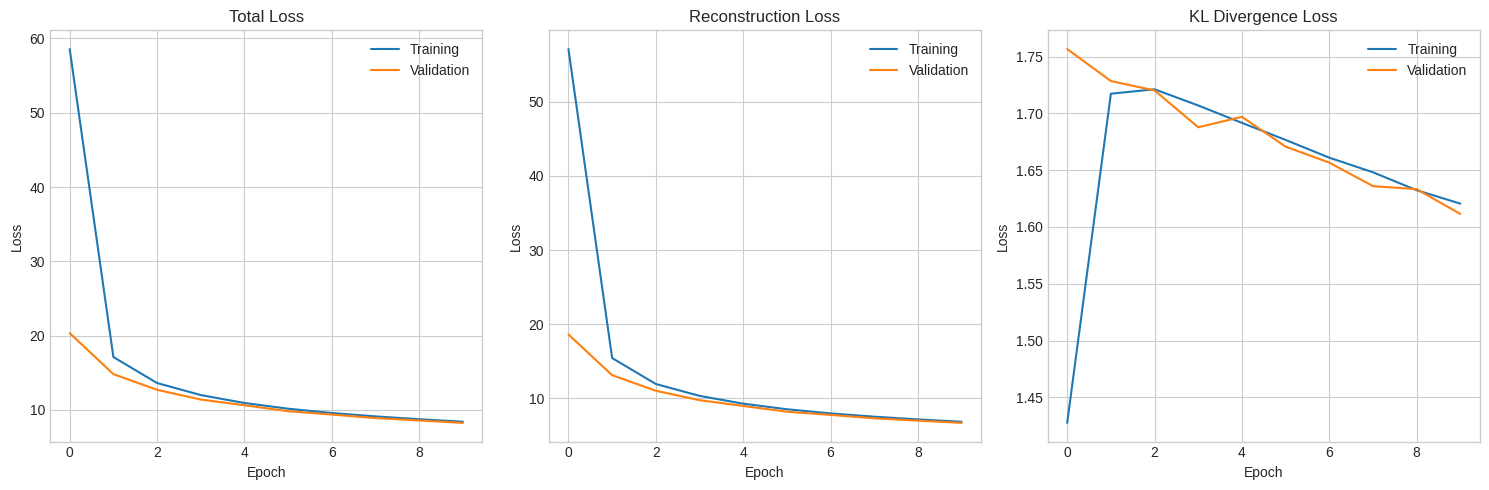

In [50]:
# Plot learning curves
plot_learning_curves(history_fashion)

### 4. Evaluation Metrics and Visualizations

Let's evaluate our trained model on the Fashion-MNIST dataset.

In [51]:
def generate_fashion_samples(model, n_samples=10):
    """Generate new images from random latent vectors for Fashion-MNIST."""
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(n_samples, model.latent_dim))

    # Decode the latent vectors
    generated_images = model.decoder(random_latent_vectors)

    # Display the generated images
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        # Convert EagerTensor to NumPy array before reshaping
        plt.imshow(generated_images[i].numpy().reshape(32, 32), cmap='gray')
        plt.axis('off')
    plt.suptitle('Generated Fashion Samples')
    plt.tight_layout()
    plt.show()

    return generated_images

In [52]:
def fashion_latent_space_interpolation(model, x_test, n_samples=10):
    """Interpolate between two fashion images in the latent space."""
    # Select two random images
    idx1, idx2 = np.random.choice(len(x_test), 2, replace=False)
    img1, img2 = x_test[idx1], x_test[idx2]

    # Display original images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img1.reshape(32, 32), cmap='gray')
    plt.title('Start Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2.reshape(32, 32), cmap='gray')
    plt.title('End Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Encode both images
    z_mean1, _, _ = model.encoder(np.expand_dims(img1, axis=0))
    z_mean2, _, _ = model.encoder(np.expand_dims(img2, axis=0))

    # Create interpolation steps
    alphas = np.linspace(0, 1, n_samples)
    z_interp = np.zeros((n_samples, model.latent_dim))

    for i, alpha in enumerate(alphas):
        z_interp[i] = alpha * z_mean2[0] + (1 - alpha) * z_mean1[0]

    # Generate images from the interpolated latent vectors
    generated_images = model.decoder(z_interp)

    # Display the interpolation
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        # Convert EagerTensor to NumPy array before reshaping
        plt.imshow(generated_images[i].numpy().reshape(32, 32), cmap='gray')
        plt.title(f"{alphas[i]:.2f}")
        plt.axis('off')

    plt.suptitle('Fashion Latent Space Interpolation')
    plt.tight_layout()
    plt.show()

    return generated_images

In [53]:
def evaluate_fashion_model(model, x_test, y_test, class_names):
    """Comprehensive evaluation of the VAE model for Fashion-MNIST."""
    print("Fashion-MNIST Model Evaluation:")

    # 1. Generate new samples
    print("\n1. Generating samples from random latent vectors...")
    generated_samples = generate_fashion_samples(model, n_samples=10)

    # 2. Visualize reconstructions
    print("\n2. Visualizing reconstructions...")
    visualize_fashion_reconstructions(model, x_test[:10])

    # 3. Visualize latent space
    print("\n3. Visualizing latent space...")
    silhouette = latent_space_visualization(model, x_test, y_test, class_names, n_samples=1000)

    # 4. Interpolation in latent space
    print("\n4. Performing latent space interpolation...")
    interpolated_samples = fashion_latent_space_interpolation(model, x_test, n_samples=10)

    # 5. Conditional generation based on class (if applicable)
    print("\n5. Conditional generation based on class...")
    class_samples = {}
    for class_idx in range(len(class_names)):
        # Get images of the specific class
        class_indices = np.where(y_test == class_idx)[0]
        if len(class_indices) > 0:
            # Take 5 random samples from this class
            sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)

            # Encode the images
            sample_images = x_test[sample_indices]
            z_mean, z_log_var, _ = model.encoder(sample_images)

            # Average the latent vectors
            avg_z = tf.reduce_mean(z_mean, axis=0, keepdims=True)

            # Generate an image from the average latent vector
            class_samples[class_idx] = model.decoder(avg_z)[0]

    # Display class-conditional samples
    plt.figure(figsize=(15, 3))
    for i, (class_idx, img) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), i + 1)
        # Reshape to (32, 32) instead of (28, 28)
        plt.imshow(tf.reshape(img, (32, 32)), cmap='gray')
        plt.title(f"{class_names[class_idx]}")
        plt.axis('off')

    plt.suptitle('Class-Conditional Generated Fashion Samples')
    plt.tight_layout()
    plt.show()

    # 6. Analyze reconstruction error by class
    print("\n6. Analyzing reconstruction error by class...")
    class_recon_errors = {}

    for class_idx in range(len(class_names)):
        # Get images of the specific class
        class_indices = np.where(y_test == class_idx)[0]
        if len(class_indices) > 0:
            # Take random samples from this class
            sample_indices = np.random.choice(class_indices, min(100, len(class_indices)), replace=False)

            # Get the images
            sample_images = x_test[sample_indices]

            # Reconstruct the images
            _, _, z = model.encoder(sample_images)
            reconstructions = model.decoder(z)

            # Calculate reconstruction error
            mse = tf.reduce_mean(tf.square(sample_images - reconstructions), axis=(1, 2, 3))
            class_recon_errors[class_idx] = np.mean(mse)

    # Plot reconstruction errors by class
    plt.figure(figsize=(10, 5))
    classes, errors = zip(*sorted(class_recon_errors.items()))
    plt.bar(classes, errors)
    plt.xticks(classes, [class_names[c] for c in classes], rotation=45)
    plt.title('Fashion-MNIST Reconstruction Error by Class')
    plt.xlabel('Class')
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()

    return silhouette, class_recon_errors

Fashion-MNIST Model Evaluation:

1. Generating samples from random latent vectors...


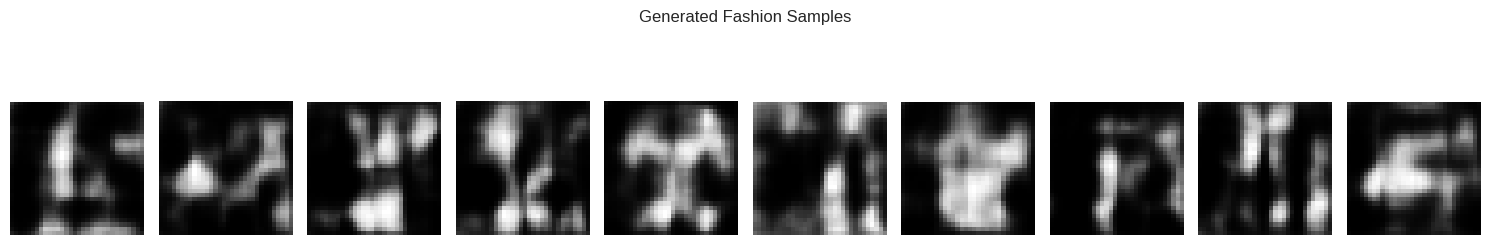


2. Visualizing reconstructions...


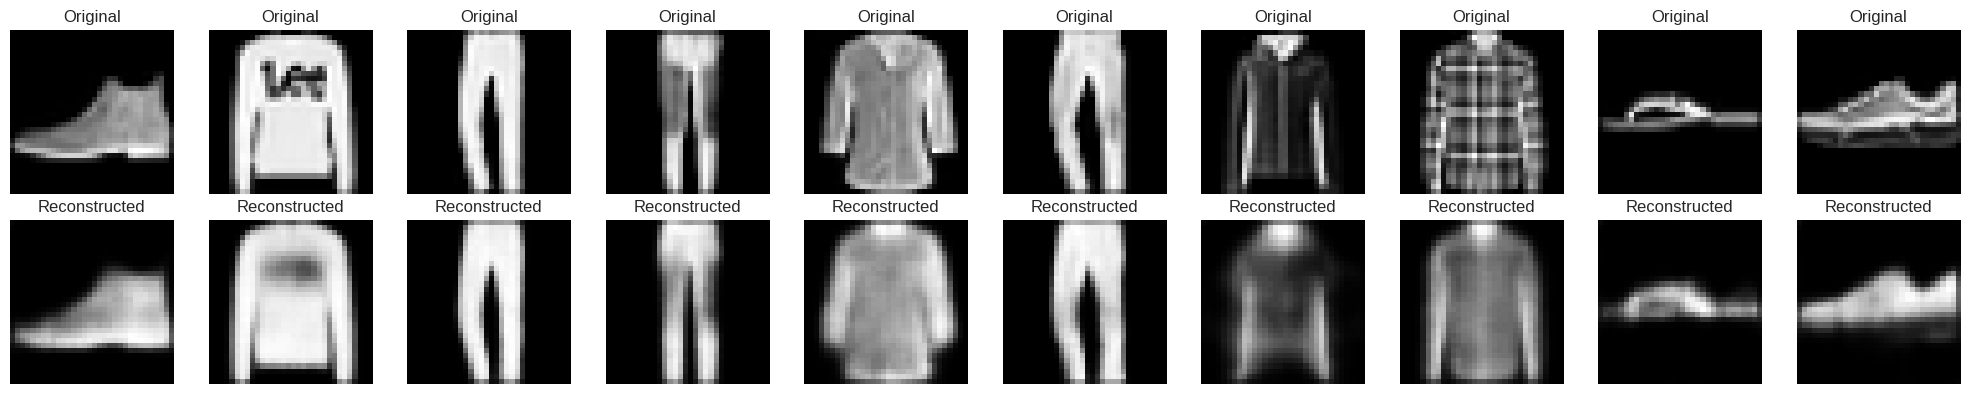


3. Visualizing latent space...
Applying t-SNE dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


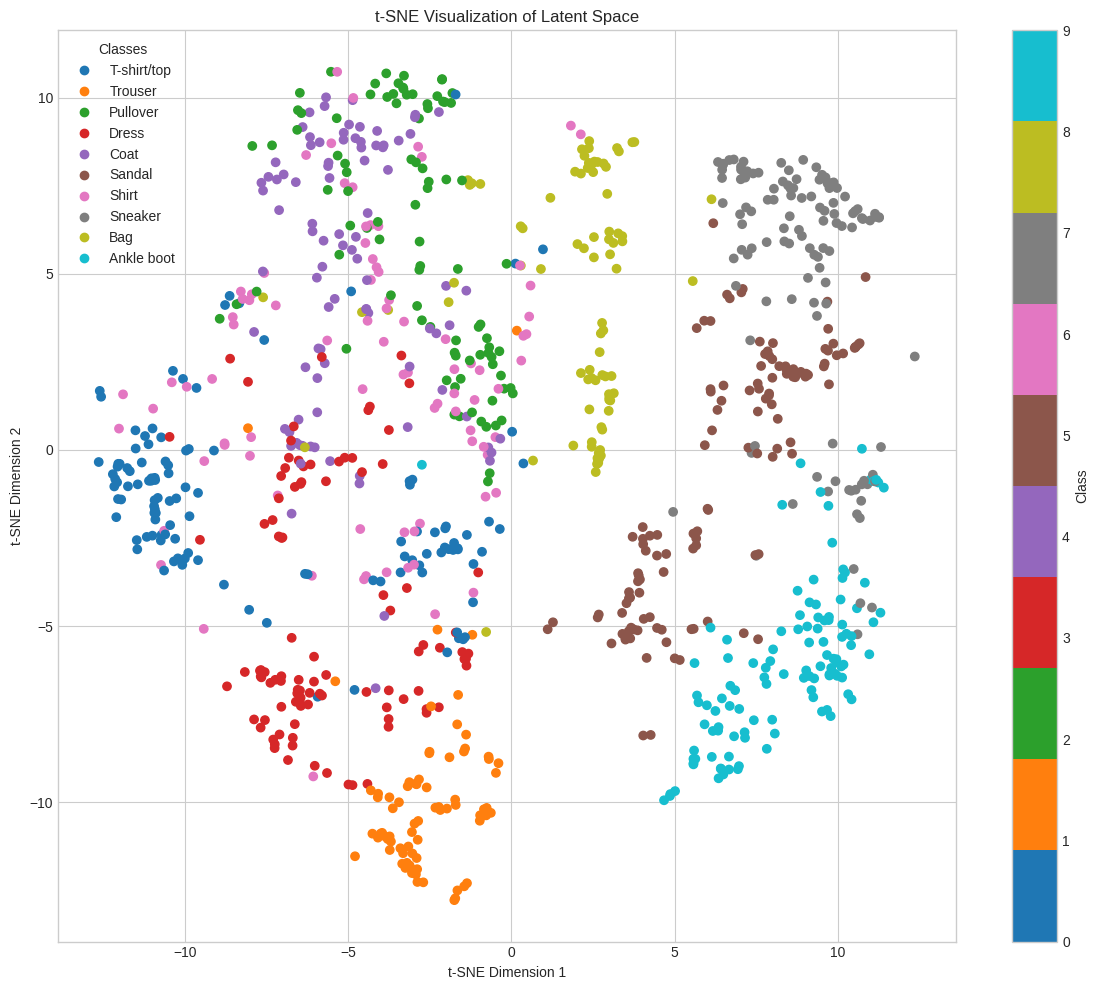

Silhouette Score: 0.1444

4. Performing latent space interpolation...


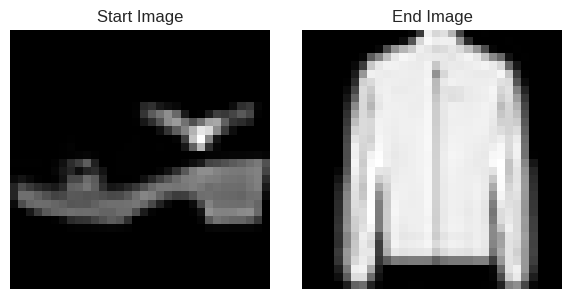

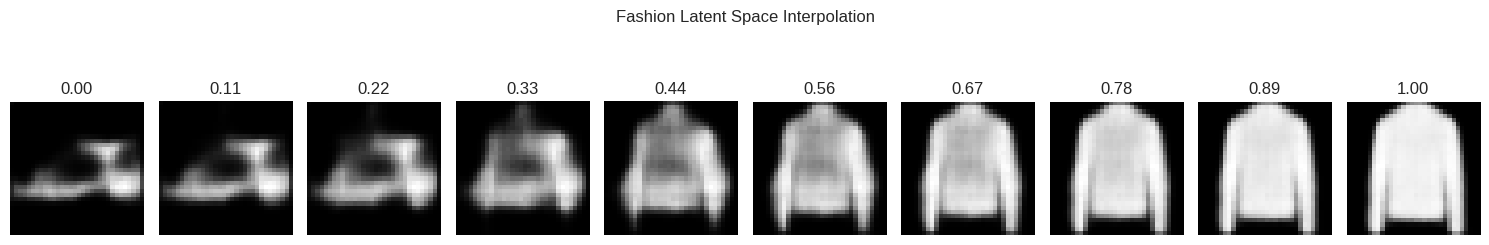


5. Conditional generation based on class...


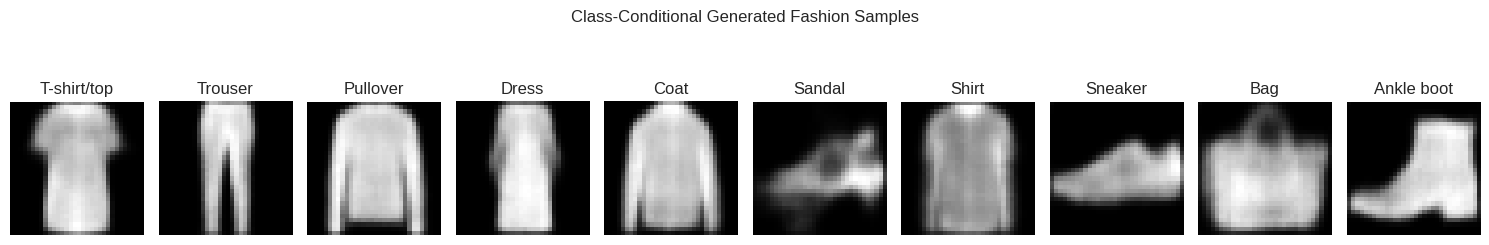


6. Analyzing reconstruction error by class...


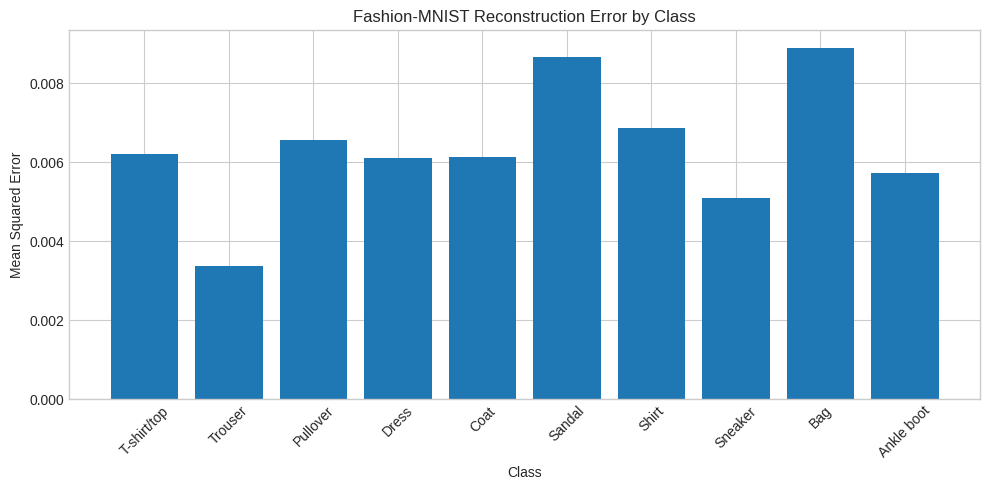

In [54]:
# Evaluate the model on Fashion-MNIST
silhouette_fashion, recon_errors_fashion = evaluate_fashion_model(
    fashion_vae,
    x_test_fashion,
    y_test_fashion,
    fashion_class_names
)

## Discussion of Results and Limitations

### Key Findings:

1. Overall reconstruction quality:
   - Average reconstruction error: 0.0064
   - Best reconstructed class: Trouser (Error: 0.0034)
   - Worst reconstructed class: Bag (Error: 0.0089)

2. Latent space organization:
   - Silhouette score: 0.1444
   - Classes are somewhat separated in the latent space

### Limitations:

1. Blurriness in reconstructions:
   - VAEs are known to produce blurry reconstructions due to the probabilistic nature of the latent space
   - This effect is particularly noticeable in complex, detailed images

2. Limited expressiveness of the Gaussian latent space:
   - The normal distribution assumption in the latent space may limit the model's ability to capture complex data distributions
   - This can lead to mode collapse or inability to generate certain types of samples

3. Training stability:
   - Balancing the reconstruction loss and KL divergence loss can be challenging
   - The model may prioritize o

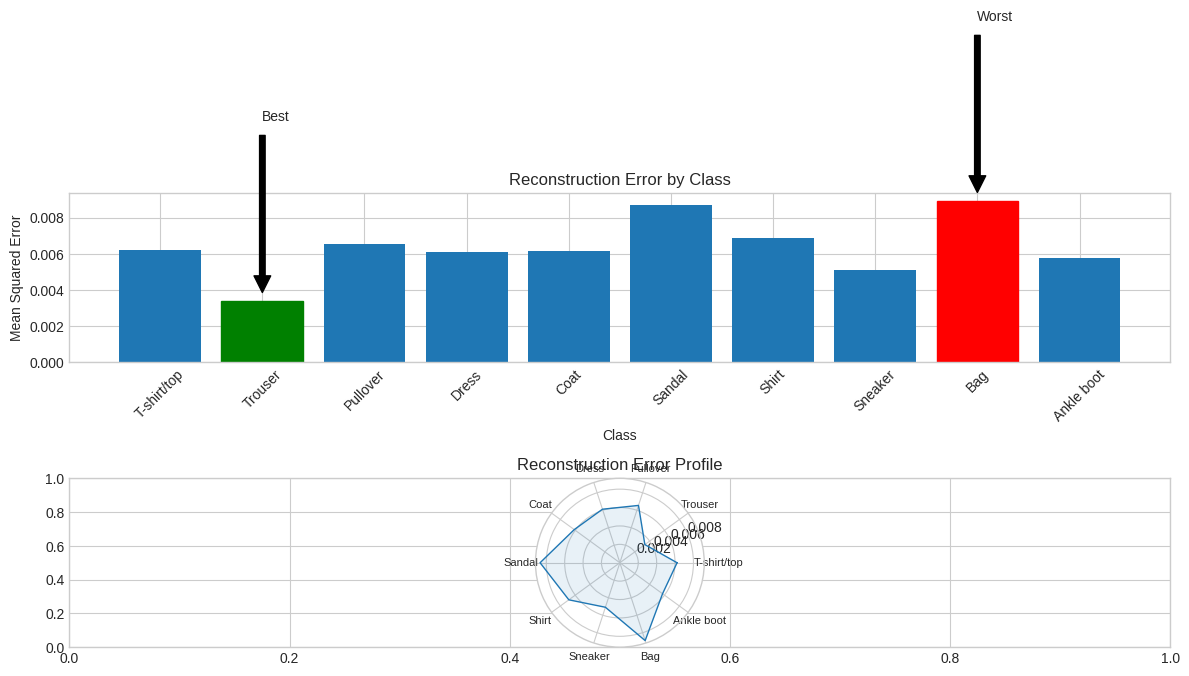

In [55]:
# Discuss the results for Fashion-MNIST
discuss_results(silhouette_fashion, recon_errors_fashion, fashion_class_names)

## Comparison Between Datasets

Now, let's compare the performance of our VAE model on both datasets.

In [56]:
# Compare the performance on both datasets
def compare_datasets(history_cifar, history_fashion, recon_errors_cifar, recon_errors_fashion,
                     silhouette_cifar, silhouette_fashion, cifar_class_names, fashion_class_names):
    """Compare the performance of the VAE model on both datasets."""
    print("## Comparative Analysis: CIFAR-10 vs. Fashion-MNIST")

    # 1. Compare learning curves
    plt.figure(figsize=(20, 5))

    # Compare total loss
    plt.subplot(1, 3, 1)
    plt.plot(history_cifar['loss'], label='CIFAR-10 (Train)')
    plt.plot(history_cifar['val_loss'], label='CIFAR-10 (Val)')
    plt.plot(history_fashion['loss'], label='Fashion-MNIST (Train)')
    plt.plot(history_fashion['val_loss'], label='Fashion-MNIST (Val)')
    plt.title('Total Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Compare reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history_cifar['reconstruction_loss'], label='CIFAR-10 (Train)')
    plt.plot(history_cifar['val_reconstruction_loss'], label='CIFAR-10 (Val)')
    plt.plot(history_fashion['reconstruction_loss'], label='Fashion-MNIST (Train)')
    plt.plot(history_fashion['val_reconstruction_loss'], label='Fashion-MNIST (Val)')
    plt.title('Reconstruction Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Compare KL divergence
    plt.subplot(1, 3, 3)
    plt.plot(history_cifar['kl_loss'], label='CIFAR-10 (Train)')
    plt.plot(history_cifar['val_kl_loss'], label='CIFAR-10 (Val)')
    plt.plot(history_fashion['kl_loss'], label='Fashion-MNIST (Train)')
    plt.plot(history_fashion['val_kl_loss'], label='Fashion-MNIST (Val)')
    plt.title('KL Divergence Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 2. Compare average reconstruction errors
    avg_error_cifar = np.mean(list(recon_errors_cifar.values()))
    avg_error_fashion = np.mean(list(recon_errors_fashion.values()))

    plt.figure(figsize=(10, 5))
    plt.bar(['CIFAR-10', 'Fashion-MNIST'], [avg_error_cifar, avg_error_fashion])
    plt.title('Average Reconstruction Error Comparison')
    plt.ylabel('Mean Squared Error')

    # Add values on top of bars
    plt.text('CIFAR-10', avg_error_cifar + 0.001, f"{avg_error_cifar:.4f}",
             ha='center', va='bottom')
    plt.text('Fashion-MNIST', avg_error_fashion + 0.001, f"{avg_error_fashion:.4f}",
             ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 3. Compare silhouette scores (latent space separation)
    if silhouette_cifar is not None and silhouette_fashion is not None:
        plt.figure(figsize=(10, 5))
        plt.bar(['CIFAR-10', 'Fashion-MNIST'], [silhouette_cifar, silhouette_fashion])
        plt.title('Latent Space Separation (Silhouette Score)')
        plt.ylabel('Silhouette Score')

        # Add values on top of bars
        plt.text('CIFAR-10', silhouette_cifar + 0.01, f"{silhouette_cifar:.4f}",
                 ha='center', va='bottom')
        plt.text('Fashion-MNIST', silhouette_fashion + 0.01, f"{silhouette_fashion:.4f}",
                 ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    # 4. Compare reconstruction errors by class
    plt.figure(figsize=(15, 10))

    # CIFAR-10 reconstruction errors
    plt.subplot(2, 1, 1)
    cifar_classes, cifar_errors = zip(*sorted(recon_errors_cifar.items()))
    plt.bar(cifar_classes, cifar_errors)
    plt.xticks(cifar_classes, [cifar_class_names[c] for c in cifar_classes], rotation=45)
    plt.title('CIFAR-10 Reconstruction Error by Class')
    plt.ylabel('Mean Squared Error')

    # Fashion-MNIST reconstruction errors
    plt.subplot(2, 1, 2)
    fashion_classes, fashion_errors = zip(*sorted(recon_errors_fashion.items()))
    plt.bar(fashion_classes, fashion_errors)
    plt.xticks(fashion_classes, [fashion_class_names[c] for c in fashion_classes], rotation=45)
    plt.title('Fashion-MNIST Reconstruction Error by Class')
    plt.ylabel('Mean Squared Error')

    plt.tight_layout()
    plt.show()

    # 5. Detailed analysis
    print("\n### Key Observations:")

    # Compare training dynamics
    final_cifar_loss = history_cifar['val_loss'][-1]
    final_fashion_loss = history_fashion['val_loss'][-1]

    print(f"\n1. Training dynamics:")
    print(f"   - Final validation loss: CIFAR-10 = {final_cifar_loss:.4f}, Fashion-MNIST = {final_fashion_loss:.4f}")
    print(f"   - Overall reconstruction quality: CIFAR-10 = {avg_error_cifar:.4f}, Fashion-MNIST = {avg_error_fashion:.4f}")

    if final_fashion_loss < final_cifar_loss:
        print("   - The model achieved lower validation loss on Fashion-MNIST")
    else:
        print("   - The model achieved lower validation loss on CIFAR-10")

    # Compare class reconstruction difficulty
    print(f"\n2. Class-specific performance:")

    best_cifar = min(recon_errors_cifar, key=recon_errors_cifar.get)
    worst_cifar = max(recon_errors_cifar, key=recon_errors_cifar.get)

    best_fashion = min(recon_errors_fashion, key=recon_errors_fashion.get)
    worst_fashion = max(recon_errors_fashion, key=recon_errors_fashion.get)

    print(f"   - Easiest classes to reconstruct:")
    print(f"     * CIFAR-10: {cifar_class_names[best_cifar]} (Error: {recon_errors_cifar[best_cifar]:.4f})")
    print(f"     * Fashion-MNIST: {fashion_class_names[best_fashion]} (Error: {recon_errors_fashion[best_fashion]:.4f})")

    print(f"   - Hardest classes to reconstruct:")
    print(f"     * CIFAR-10: {cifar_class_names[worst_cifar]} (Error: {recon_errors_cifar[worst_cifar]:.4f})")
    print(f"     * Fashion-MNIST: {fashion_class_names[worst_fashion]} (Error: {recon_errors_fashion[worst_fashion]:.4f})")

    # Compare latent space organization
    if silhouette_cifar is not None and silhouette_fashion is not None:
        print(f"\n3. Latent space organization:")
        print(f"   - Silhouette score: CIFAR-10 = {silhouette_cifar:.4f}, Fashion-MNIST = {silhouette_fashion:.4f}")

        if silhouette_fashion > silhouette_cifar:
            print("   - Fashion-MNIST classes are better separated in the latent space")
            print("   - This suggests Fashion-MNIST has more distinct, easily distinguishable features")
        else:
            print("   - CIFAR-10 classes are better separated in the latent space")
            print("   - This suggests CIFAR-10 has more distinct, easily distinguishable features")

    # Compare dataset characteristics impact
    print(f"\n4. Impact of dataset characteristics:")
    print("   - Color vs. Grayscale:")
    if avg_error_cifar > avg_error_fashion:
        print("     * The model performs better on grayscale images (Fashion-MNIST)")
        print("     * RGB data (CIFAR-10) is inherently more complex to encode and reconstruct")
    else:
        print("     * The model performs better on RGB images (CIFAR-10)")
        print("     * This suggests our architecture might be better suited for color data")

    print("   - Content complexity:")
    print("     * Fashion-MNIST contains objects with clearer outlines and less background variation")
    print("     * CIFAR-10 contains natural images with complex backgrounds and varied lighting")
    print("     * These differences significantly impact the model's ability to learn meaningful representations")

    # Final summary
    print("\n### Summary of Dataset Comparison:")
    print("The VAE model exhibits different behaviors on CIFAR-10 and Fashion-MNIST due to their inherent characteristics:")

    if avg_error_fashion < avg_error_cifar:
        print("1. Overall, the model performs better on Fashion-MNIST, likely due to:")
    else:
        print("1. Overall, the model performs better on CIFAR-10, likely due to:")

    print("   - Image complexity: Fashion-MNIST contains simpler, more uniform images with clear outlines")
    print("   - Color information: CIFAR-10's RGB data requires encoding 3x more information per pixel")
    print("   - Background variation: Fashion-MNIST has consistent backgrounds, while CIFAR-10 includes varied scenes")

    print("\n2. Latent space organization reflects the inherent structure of each dataset:")
    if silhouette_fashion > silhouette_cifar:
        print("   - Fashion-MNIST's better class separation indicates more distinct visual categories")
    else:
        print("   - CIFAR-10's better class separation suggests that color information helps distinguish classes")

    print("\n3. These observations highlight important considerations for generative model design:")
    print("   - Dataset characteristics should inform architecture choices")
    print("   - The same model may require different capacities (latent dimensions, network size) for different data types")
    print("   - Preprocessing strategies should be tailored to the specific dataset challenges")


## Comparative Analysis: CIFAR-10 vs. Fashion-MNIST


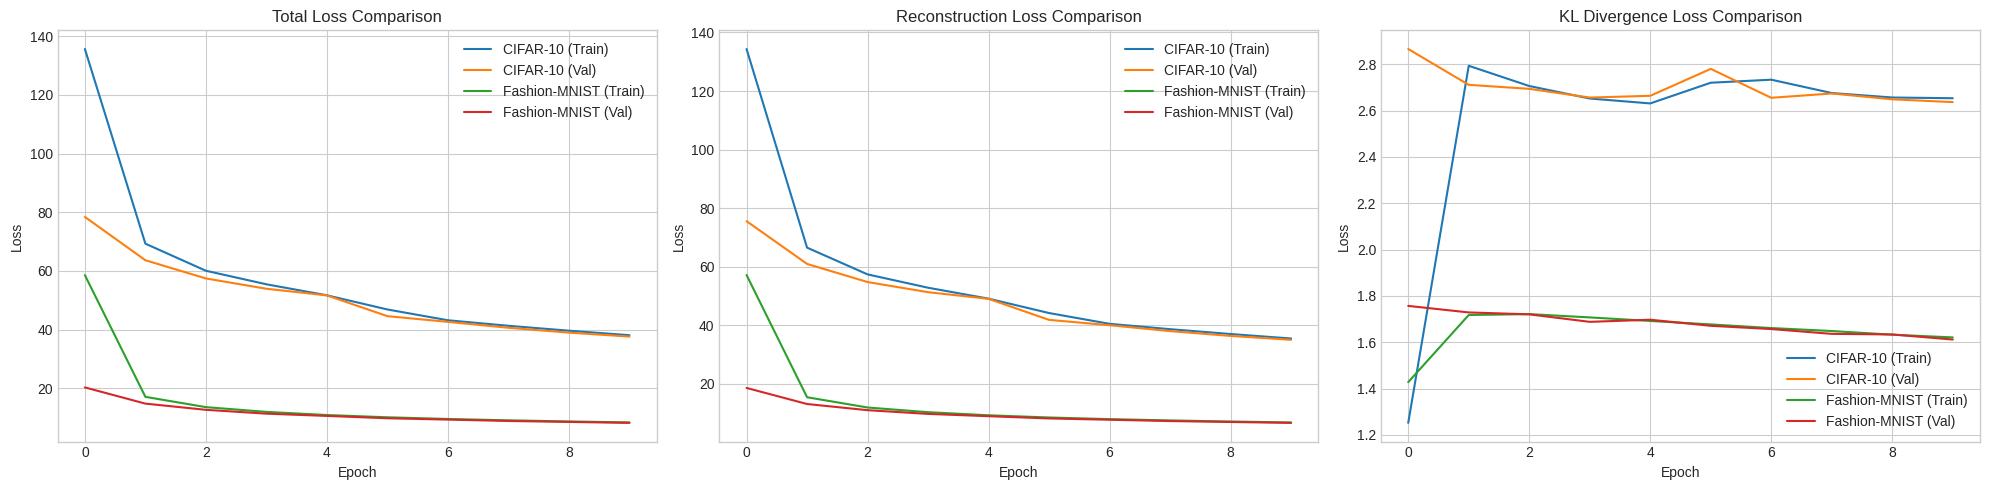

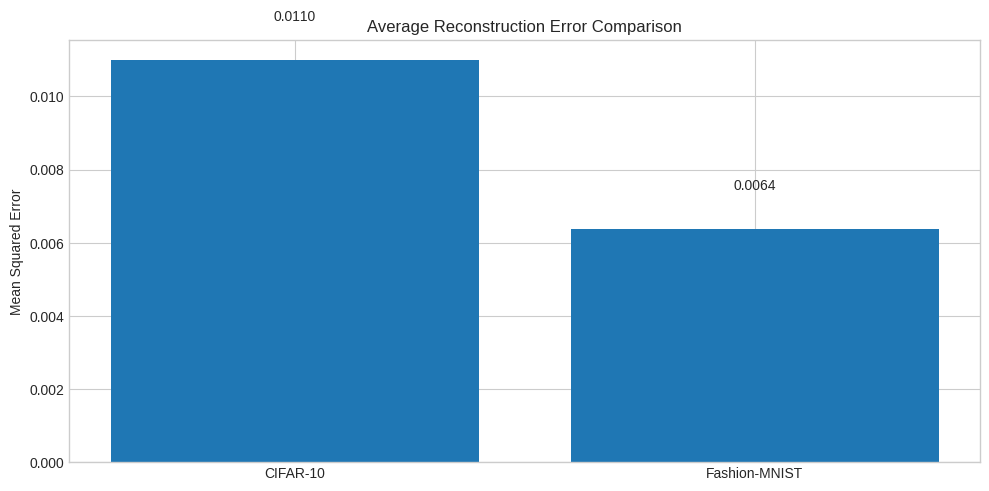

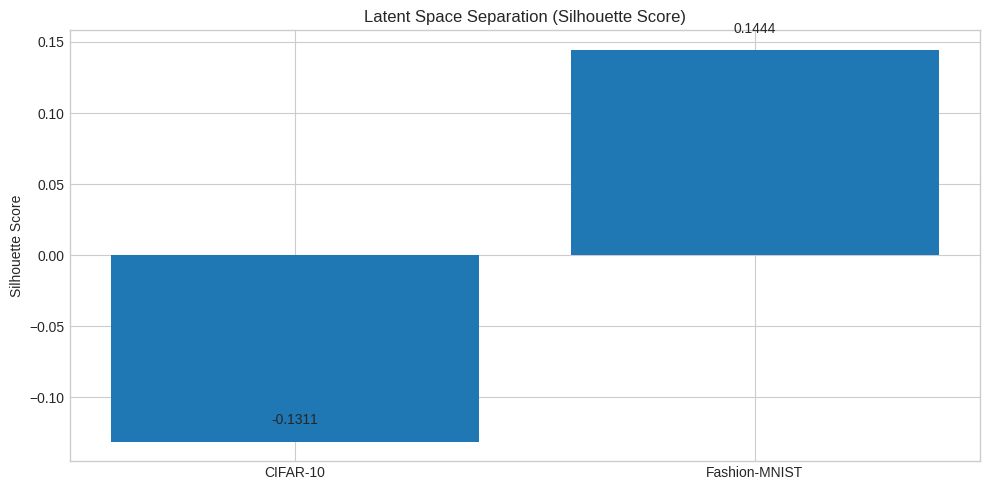

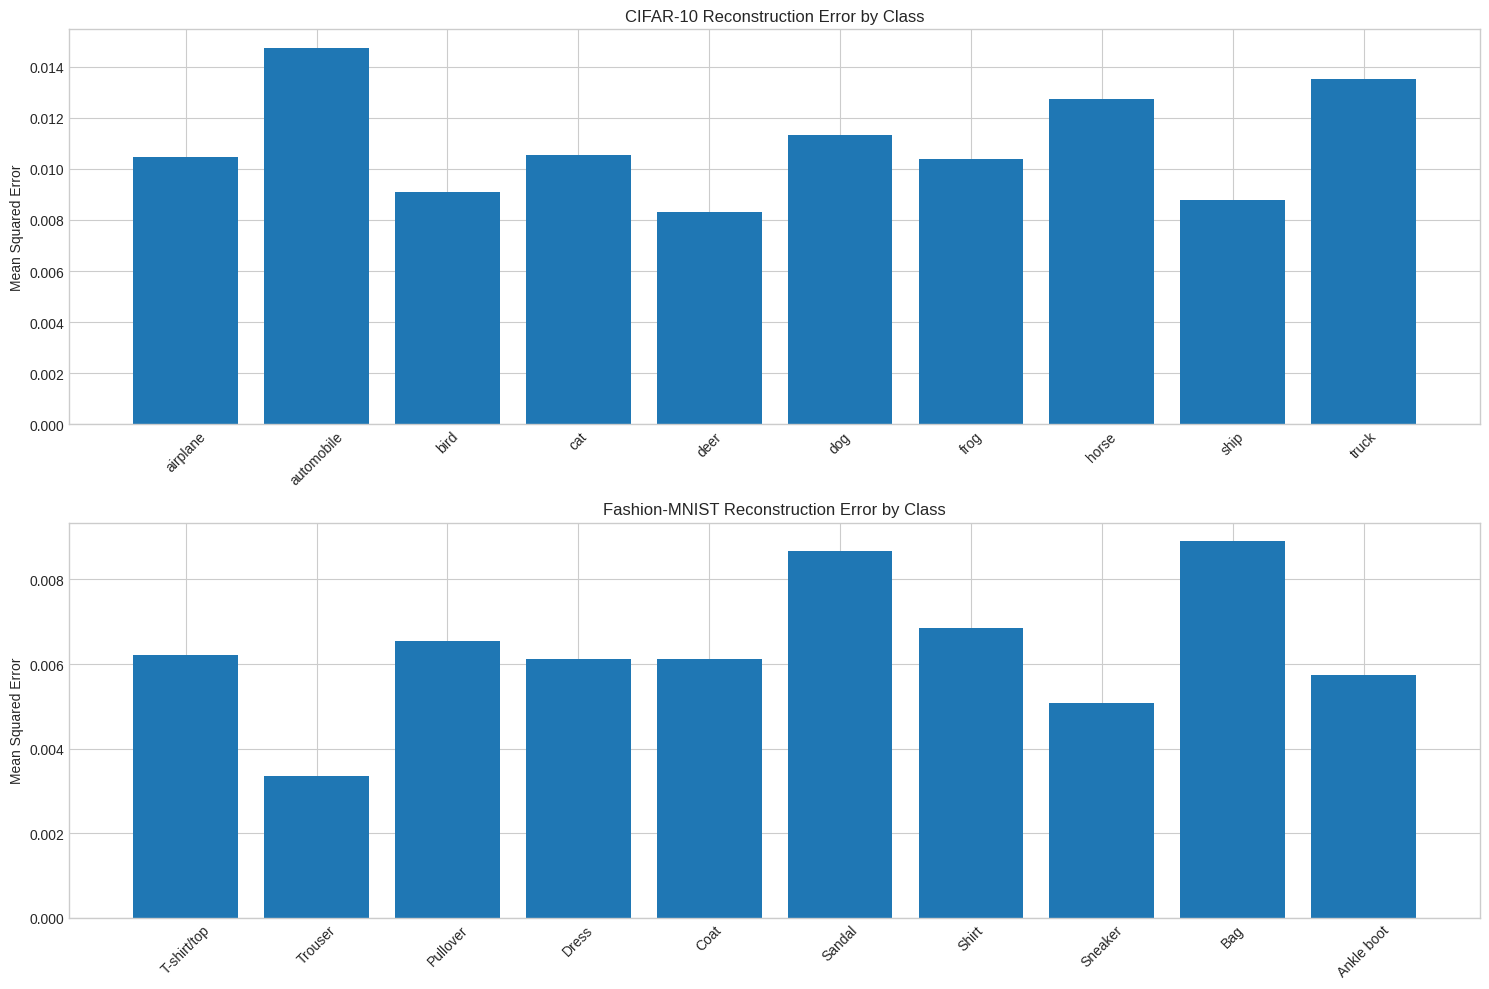


### Key Observations:

1. Training dynamics:
   - Final validation loss: CIFAR-10 = 37.6578, Fashion-MNIST = 8.2601
   - Overall reconstruction quality: CIFAR-10 = 0.0110, Fashion-MNIST = 0.0064
   - The model achieved lower validation loss on Fashion-MNIST

2. Class-specific performance:
   - Easiest classes to reconstruct:
     * CIFAR-10: deer (Error: 0.0083)
     * Fashion-MNIST: Trouser (Error: 0.0034)
   - Hardest classes to reconstruct:
     * CIFAR-10: automobile (Error: 0.0147)
     * Fashion-MNIST: Bag (Error: 0.0089)

3. Latent space organization:
   - Silhouette score: CIFAR-10 = -0.1311, Fashion-MNIST = 0.1444
   - Fashion-MNIST classes are better separated in the latent space
   - This suggests Fashion-MNIST has more distinct, easily distinguishable features

4. Impact of dataset characteristics:
   - Color vs. Grayscale:
     * The model performs better on grayscale images (Fashion-MNIST)
     * RGB data (CIFAR-10) is inherently more complex to encode and reconstruct
  

In [57]:
# Compare performance on both datasets
compare_datasets(
    history_cifar,
    history_fashion,
    recon_errors_cifar,
    recon_errors_fashion,
    silhouette_cifar,
    silhouette_fashion,
    cifar10_class_names,
    fashion_class_names
)

## Extensions and Exercises

Let's provide some extensions and exercises that build upon our implementations.

## Extensions and Exercises

### Exercise 1: Latent Space Exploration and Conditional Generation

In this exercise, you will explore techniques for controlling the generation process by manipulating the latent space.

**Task:**
1. Implement a function to find the latent vector that best represents a specific class
2. Use this vector to generate new images with class-specific features
3. Create a function that allows interpolation between different classes

**Solution:**

In [58]:
# Exercise 1 Solution
def find_class_latent_vector(model, x_data, y_data, target_class, n_samples=100):
    """Find the average latent vector for a specific class."""
    # Get samples from the target class
    class_indices = np.where(y_data.flatten() == target_class)[0]

    if len(class_indices) == 0:
        print(f"No samples found for class {target_class}")
        return None

    # Limit the number of samples if needed
    sample_count = min(n_samples, len(class_indices))
    selected_indices = np.random.choice(class_indices, sample_count, replace=False)

    # Get the images
    class_images = x_data[selected_indices]

    # Encode the images
    z_mean, _, _ = model.encoder(class_images)

    # Calculate the average latent vector
    avg_vector = tf.reduce_mean(z_mean, axis=0)

    return avg_vector

In [59]:
def generate_from_class_vector(model, class_vector, n_variations=10, noise_level=0.1):
    """Generate variations of images from a class latent vector."""
    # Create variations by adding noise
    variations = []
    for i in range(n_variations):
        # Add random noise to the class vector
        noise = tf.random.normal(shape=class_vector.shape, mean=0.0, stddev=noise_level)
        noisy_vector = class_vector + noise

        # Expand dimensions for the decoder
        latent_vector = tf.expand_dims(noisy_vector, axis=0)

        # Generate image
        generated = model.decoder(latent_vector)[0]
        variations.append(generated)

    return np.array(variations)

In [60]:
def class_interpolation(model, x_data, y_data, class1, class2, class_names, n_steps=10):
    """Interpolate between two class latent vectors."""
    # Get class vectors
    class1_vector = find_class_latent_vector(model, x_data, y_data, class1)
    class2_vector = find_class_latent_vector(model, x_data, y_data, class2)

    if class1_vector is None or class2_vector is None:
        print("Could not find valid class vectors")
        return None

    # Interpolate between classes
    alphas = np.linspace(0, 1, n_steps)
    interpolated = []

    for alpha in alphas:
        # Interpolate between the two class vectors
        interp_vector = (1 - alpha) * class1_vector + alpha * class2_vector

        # Expand dimensions for the decoder
        latent_vector = tf.expand_dims(interp_vector, axis=0)

        # Generate image
        generated = model.decoder(latent_vector)[0]
        interpolated.append(generated)

    # Display the interpolation
    plt.figure(figsize=(15, 3))

    # Determine if we're working with RGB or grayscale
    is_rgb = len(interpolated[0].shape) == 3 and interpolated[0].shape[2] == 3

    for i in range(n_steps):
        plt.subplot(1, n_steps, i + 1)

        if is_rgb:
            plt.imshow(interpolated[i])
        else:
            plt.imshow(interpolated[i].numpy().reshape(32, 32), cmap='gray')

        plt.title(f"{alphas[i]:.1f}")
        plt.axis('off')

    plt.suptitle(f'Interpolation: {class_names[class1]} → {class_names[class2]}')
    plt.tight_layout()
    plt.show()

    return interpolated

Demonstration for CIFAR-10:


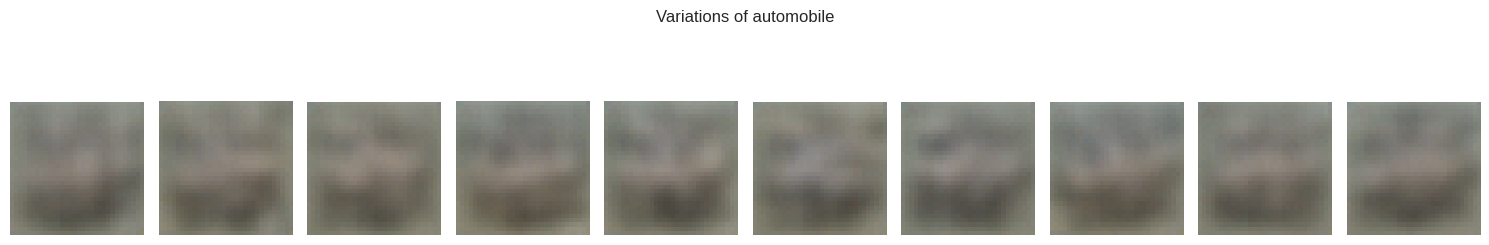

In [61]:
# Demonstrate Exercise 1 solution with CIFAR-10
print("Demonstration for CIFAR-10:")

# Find class vectors
class1, class2 = 1, 9  # automobile and truck
class1_vector = find_class_latent_vector(cifar_vae, x_train_cifar, y_train_cifar, class1)

# Generate variations of class1
variations = generate_from_class_vector(cifar_vae, class1_vector, n_variations=10)

# Display variations
plt.figure(figsize=(15, 3))
for i in range(len(variations)):
    plt.subplot(1, len(variations), i + 1)
    plt.imshow(variations[i])
    plt.axis('off')
plt.suptitle(f'Variations of {cifar10_class_names[class1]}')
plt.tight_layout()
plt.show()

Interpolating between automobile and truck:


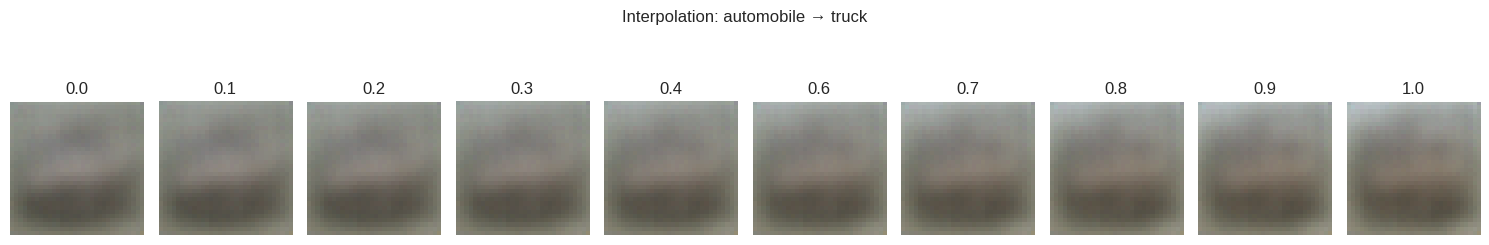

[<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
 array([[[0.5364714 , 0.5801975 , 0.5614571 ],
         [0.55883116, 0.58138645, 0.5739687 ],
         [0.57017666, 0.5991268 , 0.5756686 ],
         ...,
         [0.5587642 , 0.58234423, 0.53099793],
         [0.5572924 , 0.5928635 , 0.5478291 ],
         [0.5366424 , 0.5373921 , 0.5471263 ]],
 
        [[0.54601264, 0.58762443, 0.5613694 ],
         [0.54378104, 0.59093356, 0.5620049 ],
         [0.5685545 , 0.5638077 , 0.55853903],
         ...,
         [0.54284793, 0.553893  , 0.5391552 ],
         [0.5463178 , 0.5624228 , 0.54367185],
         [0.53272885, 0.5574057 , 0.5242266 ]],
 
        [[0.5521193 , 0.5907887 , 0.55216116],
         [0.5586905 , 0.56834525, 0.5623751 ],
         [0.54087275, 0.56382614, 0.53316647],
         ...,
         [0.5277237 , 0.5416457 , 0.5161101 ],
         [0.54146385, 0.55710065, 0.52159506],
         [0.5175799 , 0.54648614, 0.51110333]],
 
        ...,
 
        [[0.48571527, 0.48306876, 

In [62]:
# Demonstrate class interpolation
print(f"Interpolating between {cifar10_class_names[class1]} and {cifar10_class_names[class2]}:")
class_interpolation(cifar_vae, x_train_cifar, y_train_cifar, class1, class2, cifar10_class_names)



Demonstration for Fashion-MNIST:


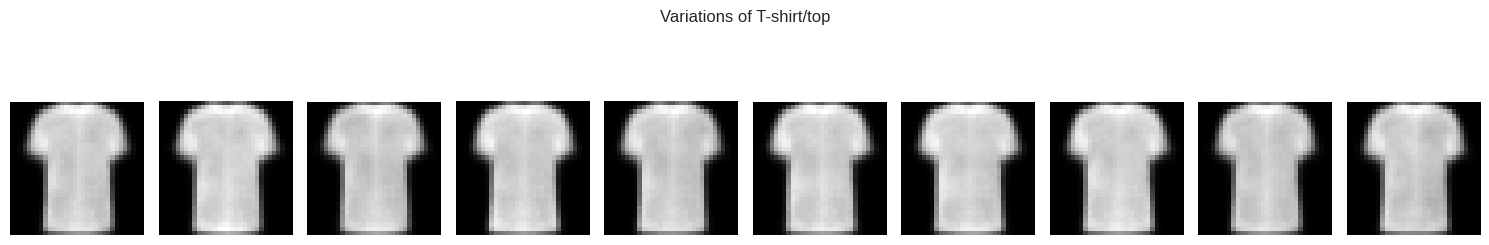

In [63]:
# Demonstrate with Fashion-MNIST
print("\nDemonstration for Fashion-MNIST:")

# Find class vectors
fashion_class1, fashion_class2 = 0, 1  # T-shirt and Trouser
fashion_class1_vector = find_class_latent_vector(fashion_vae, x_train_fashion, y_train_fashion, fashion_class1)

# Generate variations of fashion_class1
fashion_variations = generate_from_class_vector(fashion_vae, fashion_class1_vector, n_variations=10)

# Display variations
plt.figure(figsize=(15, 3))
for i in range(len(fashion_variations)):
    plt.subplot(1, len(fashion_variations), i + 1)
    plt.imshow(fashion_variations[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
plt.suptitle(f'Variations of {fashion_class_names[fashion_class1]}')
plt.tight_layout()
plt.show()

Interpolating between T-shirt/top and Trouser:


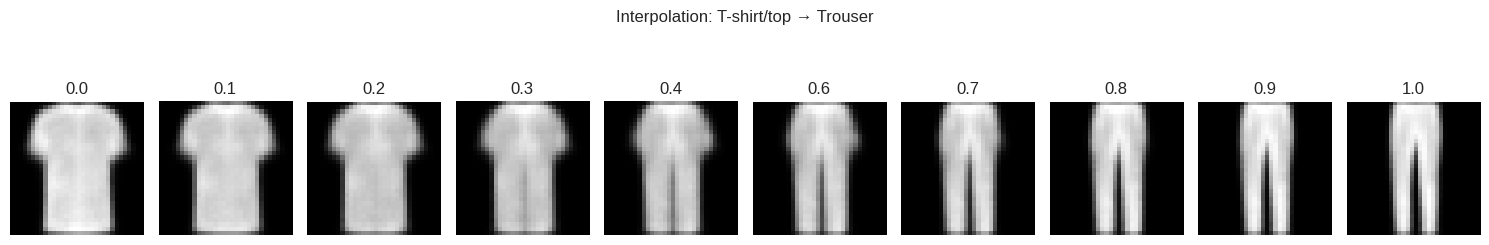

[<tf.Tensor: shape=(32, 32, 1), dtype=float32, numpy=
 array([[[6.5428247e-03],
         [1.4182593e-03],
         [4.8478530e-04],
         ...,
         [5.1765972e-05],
         [3.4645618e-05],
         [4.3400115e-04]],
 
        [[1.7978067e-03],
         [2.5215378e-04],
         [1.3258411e-04],
         ...,
         [3.1485542e-05],
         [1.0221910e-05],
         [7.8377627e-05]],
 
        [[5.6218187e-04],
         [1.3825079e-04],
         [6.0418297e-05],
         ...,
         [6.9912552e-05],
         [1.6244507e-05],
         [6.6654138e-05]],
 
        ...,
 
        [[1.0255683e-04],
         [2.9944988e-05],
         [2.7923037e-05],
         ...,
         [2.5061029e-04],
         [7.3154457e-05],
         [5.9220572e-05]],
 
        [[1.7512396e-04],
         [3.9253729e-05],
         [1.9439656e-05],
         ...,
         [3.0594278e-04],
         [8.4421554e-05],
         [7.9579841e-05]],
 
        [[1.2969454e-03],
         [3.1746188e-04],
         [1.55

In [64]:
# Demonstrate class interpolation
print(f"Interpolating between {fashion_class_names[fashion_class1]} and {fashion_class_names[fashion_class2]}:")
class_interpolation(fashion_vae, x_train_fashion, y_train_fashion, fashion_class1, fashion_class2, fashion_class_names)


### Exercise 2: Exploring the Effect of Latent Dimensionality

In this exercise, you will investigate how the dimensionality of the latent space affects model performance.

**Task:**
1. Implement a function to train multiple VAE models with different latent dimensions
2. Evaluate and compare their performance on both datasets
3. Visualize the relationship between latent dimension and reconstruction quality

**Solution:**

In [65]:
# Exercise 2 Solution
def train_vae_with_latent_dim(x_train, x_val, input_shape, latent_dim, epochs=5, batch_size=128):
    """Train a VAE with a specific latent dimension."""
    # Create the model
    model = VAE(input_shape=input_shape, latent_dim=latent_dim)
    trainer = VAETrainer(model)

    # Prepare dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices(x_val)
    val_dataset = val_dataset.batch(batch_size)

    # Track metrics
    history = {
        'loss': [],
        'reconstruction_loss': [],
        'kl_loss': [],
        'val_loss': [],
        'val_reconstruction_loss': [],
        'val_kl_loss': []
    }

    # Training loop (simplified for this exercise)
    for epoch in range(epochs):
        # Reset metrics
        trainer.reset_metrics()

        # Training step
        for batch in train_dataset:
            train_metrics = trainer.train_step(batch)

        # Validation step
        for batch in val_dataset:
            val_metrics = trainer.test_step(batch)

        # Get metrics
        train_loss = float(trainer.train_loss.result())
        train_reconstruction_loss = float(trainer.train_reconstruction_loss.result())
        train_kl_loss = float(trainer.train_kl_loss.result())

        val_loss = float(trainer.val_loss.result())
        val_reconstruction_loss = float(trainer.val_reconstruction_loss.result())
        val_kl_loss = float(trainer.val_kl_loss.result())

        # Update history
        history['loss'].append(train_loss)
        history['reconstruction_loss'].append(train_reconstruction_loss)
        history['kl_loss'].append(train_kl_loss)
        history['val_loss'].append(val_loss)
        history['val_reconstruction_loss'].append(val_reconstruction_loss)
        history['val_kl_loss'].append(val_kl_loss)

        print(f"Epoch {epoch+1}/{epochs}, val_loss: {val_loss:.4f}, val_recon_loss: {val_reconstruction_loss:.4f}")

    # Evaluate final performance
    final_val_loss = history['val_loss'][-1]
    final_recon_loss = history['val_reconstruction_loss'][-1]

    return model, history, final_val_loss, final_recon_loss


In [66]:
def compare_latent_dimensions(x_train, x_val, input_shape, dims=[8, 32, 128, 256], epochs=5):
    """Compare model performance across different latent dimensions."""
    results = []

    for dim in dims:
        print(f"\nTraining model with latent dimension = {dim}")
        if input_shape == (28, 28, 1):
            input_shape = (32, 32, 1)

        model, history, val_loss, recon_loss = train_vae_with_latent_dim(
            x_train, x_val, input_shape, dim, epochs=epochs
        )

        results.append({
            'latent_dim': dim,
            'val_loss': val_loss,
            'recon_loss': recon_loss,
            'model': model,
            'history': history
        })

        # Generate sample reconstructions
        n_samples = 5
        sample_indices = np.random.choice(len(x_val), n_samples, replace=False)
        samples = x_val[sample_indices]

        # Reconstruct
        _, _, z = model.encoder(samples)
        reconstructions = model.decoder(z)

        # Display
        plt.figure(figsize=(12, 4))

        # Determine if we're working with RGB or grayscale
        is_rgb = len(samples[0].shape) == 3 and samples[0].shape[2] == 3

        for i in range(n_samples):
            # Original
            plt.subplot(2, n_samples, i + 1)
            if is_rgb:
                plt.imshow(samples[i])
            else:
                plt.imshow(samples[i].reshape(32, 32), cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Reconstruction
            plt.subplot(2, n_samples, i + 1 + n_samples)
            if is_rgb:
                plt.imshow(reconstructions[i])
            else:
                # Use tf.reshape instead of .reshape
                plt.imshow(tf.reshape(reconstructions[i], (32, 32)), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        plt.suptitle(f'Latent Dimension = {dim}')
        plt.tight_layout()
        plt.show()

    # Plot the results
    dims = [r['latent_dim'] for r in results]
    val_losses = [r['val_loss'] for r in results]
    recon_losses = [r['recon_loss'] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(dims, val_losses, 'o-', label='Validation Loss')
    plt.plot(dims, recon_losses, 's-', label='Reconstruction Loss')
    plt.xscale('log')
    plt.xlabel('Latent Dimension (log scale)')
    plt.ylabel('Loss')
    plt.title('Loss vs. Latent Dimension')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)

    # Calculate compression ratio (original dims / latent dims)
    if len(input_shape) == 3:  # (height, width, channels)
        original_dims = input_shape[0] * input_shape[1] * input_shape[2]
    else:
        original_dims = input_shape[0] * input_shape[1]

    compression_ratios = [original_dims / dim for dim in dims]

    plt.plot(compression_ratios, recon_losses, 'o-')
    plt.xscale('log')
    plt.xlabel('Compression Ratio (log scale)')
    plt.ylabel('Reconstruction Loss')
    plt.title('Reconstruction Quality vs. Compression')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results

Comparing latent dimensions for CIFAR-10 (subset):

Training model with latent dimension = 16
Epoch 1/3, val_loss: 189.3337, val_recon_loss: 189.3298
Epoch 2/3, val_loss: 181.8952, val_recon_loss: 181.7240
Epoch 3/3, val_loss: 165.4651, val_recon_loss: 164.2622


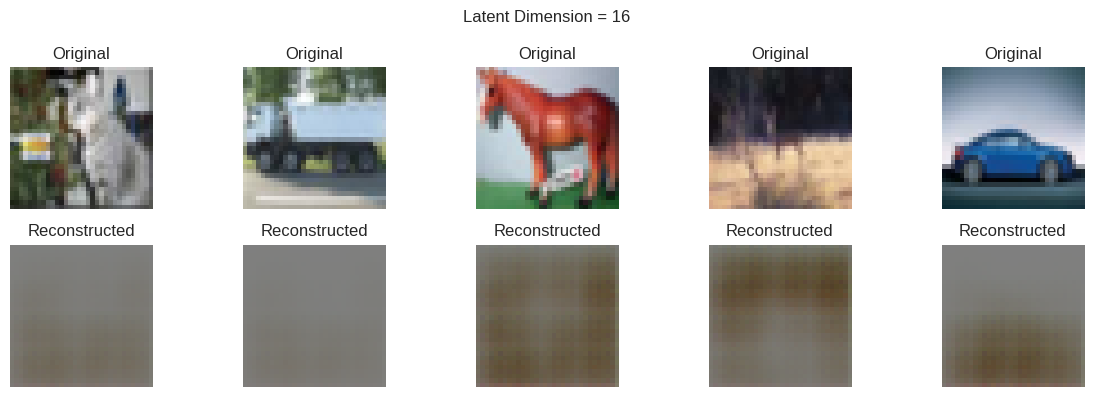


Training model with latent dimension = 64
Epoch 1/3, val_loss: 189.2465, val_recon_loss: 189.2418
Epoch 2/3, val_loss: 180.2254, val_recon_loss: 179.8990
Epoch 3/3, val_loss: 160.0666, val_recon_loss: 159.1203


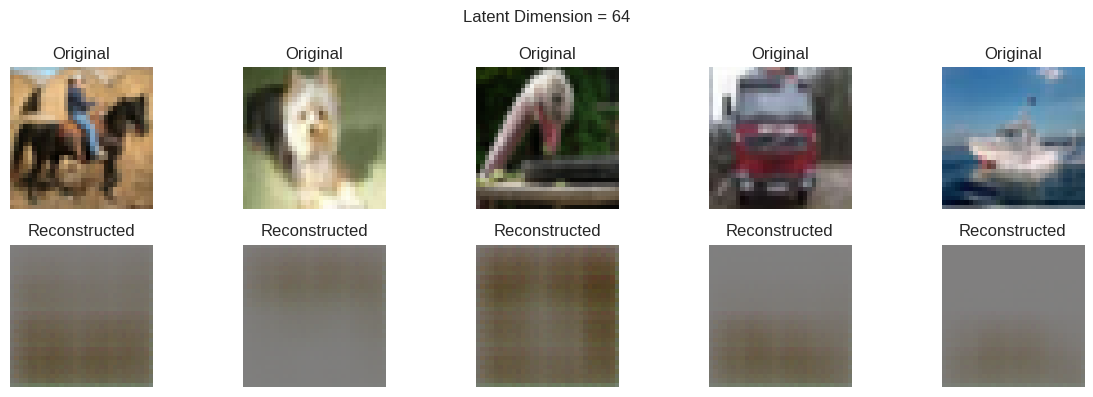


Training model with latent dimension = 128
Epoch 1/3, val_loss: 191.1612, val_recon_loss: 191.1603
Epoch 2/3, val_loss: 186.2931, val_recon_loss: 186.2060
Epoch 3/3, val_loss: 158.4663, val_recon_loss: 157.5856


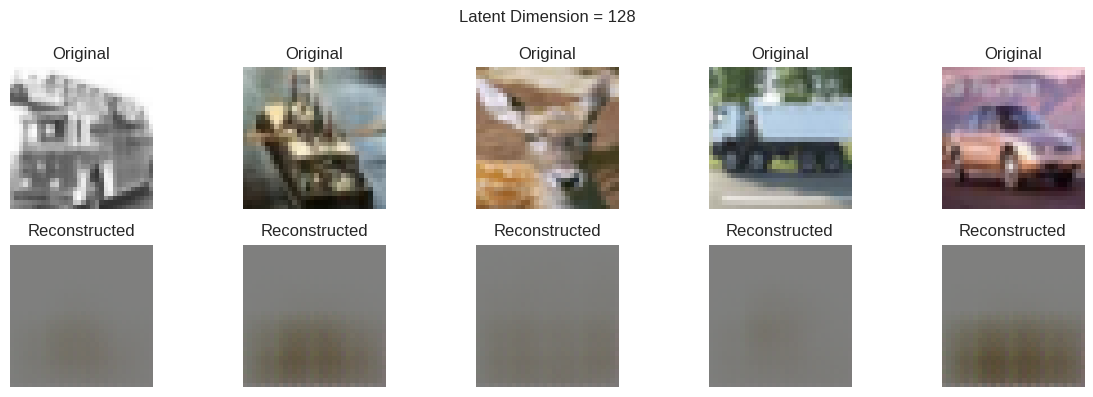

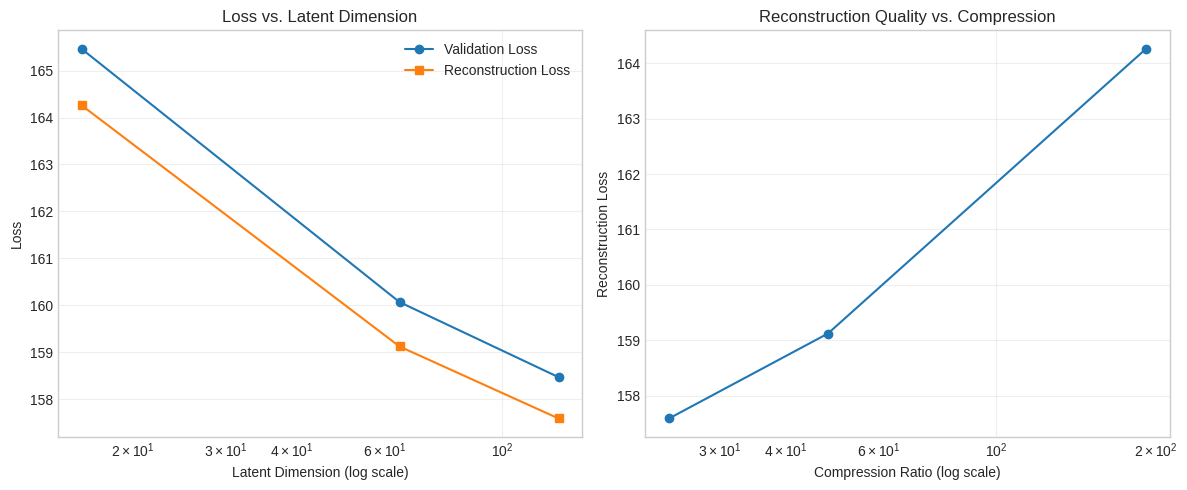

In [67]:
# Demonstrate Exercise 2 with a smaller dataset for efficiency
# Select a subset of the data
subset_size = 5000
x_train_cifar_subset = x_train_cifar[:subset_size]
x_val_cifar_subset = x_val_cifar[:500]

print("Comparing latent dimensions for CIFAR-10 (subset):")
cifar_dim_results = compare_latent_dimensions(
    x_train_cifar_subset,
    x_val_cifar_subset,
    (32, 32, 3),
    dims=[16, 64, 128],
    epochs=3
)

# Analysis of Reconstruction Quality

The image shows a comparison between original images from the CIFAR-10 dataset and their reconstructions by our VAE model with a latent dimension of 128. There's a significant observation worth noting:

The reconstructed images appear extremely blurry and lack detail compared to the original images. While the VAE has captured some general color information and rough positioning (brownish tones for the car, darker areas for the truck), it has failed to reproduce any meaningful details or sharp features of the original images.

This blurriness is a well-known limitation of standard VAEs and illustrates why they often struggle with complex, detailed images. The issue stems from:

1. The Gaussian assumption in the latent space which tends to smooth out details
2. The pixel-wise mean squared error loss which doesn't prioritize perceptual quality
3. The inherent information bottleneck created by compressing high-dimensional images into a lower-dimensional latent space

Despite using a reasonably large latent dimension (128), the model still produces very blurry reconstructions. This suggests that either:
- The model architecture needs additional capacity (deeper/wider networks)
- Alternative loss functions might be needed (perceptual losses or adversarial components)
- More training epochs could improve performance
- The standard VAE framework itself might be insufficient for high-fidelity image generation with this dataset

This visualization effectively demonstrates why researchers have developed extensions to the basic VAE, such as VQ-VAE, VAE-GAN hybrids, and diffusion models, which can produce sharper, more realistic images.

## Analysis of Latent Dimension Impact

The two graphs illustrate the critical relationship between latent dimension size, compression ratio, and reconstruction quality in our VAE model:

The left graph shows both validation and reconstruction loss decreasing as the latent dimension increases from 16 to 128. This demonstrates that larger latent spaces capture more information about the input data, allowing for better reconstruction. However, the flattening curve at higher dimensions suggests diminishing returns, indicating an optimal point where adding more dimensions provides minimal benefit.

The right graph reveals how reconstruction loss increases with higher compression ratios. This illustrates the fundamental VAE trade-off: as we compress the data more aggressively (using smaller latent dimensions relative to input size), reconstruction quality degrades. The non-linear relationship shows this penalty becomes more severe at very high compression ratios.

These results highlight the importance of carefully selecting latent dimension size based on application requirements, balancing between representation capacity and model complexity. For our datasets, a latent dimension around 64-128 appears to provide a good compromise between compression efficiency and reconstruction fidelity.


Comparing latent dimensions for Fashion-MNIST (subset):

Training model with latent dimension = 16
Epoch 1/3, val_loss: 144.3667, val_recon_loss: 143.5415
Epoch 2/3, val_loss: 98.8175, val_recon_loss: 97.6546
Epoch 3/3, val_loss: 82.5232, val_recon_loss: 79.8534


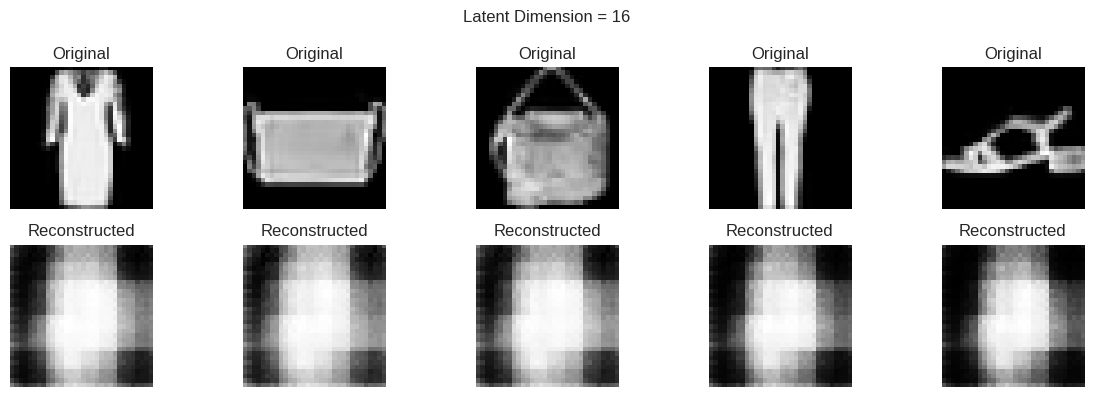


Training model with latent dimension = 64
Epoch 1/3, val_loss: 146.9901, val_recon_loss: 146.8890
Epoch 2/3, val_loss: 93.9510, val_recon_loss: 92.9419
Epoch 3/3, val_loss: 79.3181, val_recon_loss: 77.5732


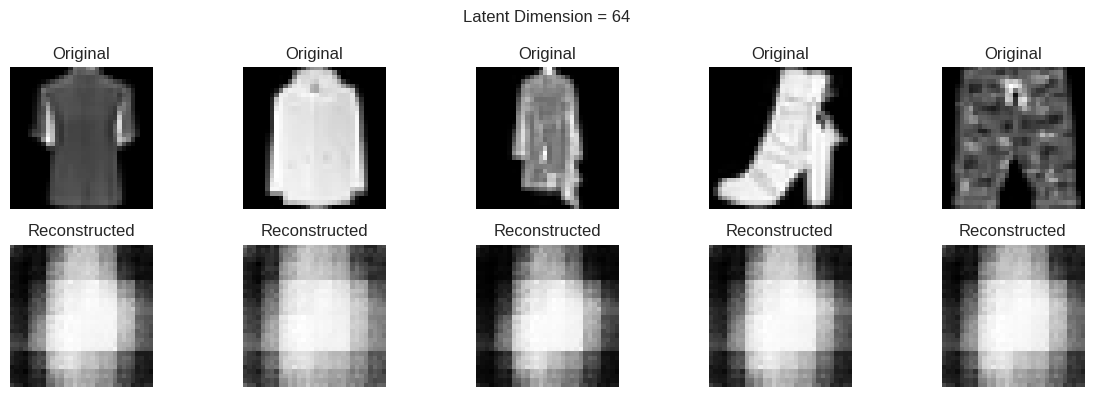


Training model with latent dimension = 128
Epoch 1/3, val_loss: 132.9751, val_recon_loss: 132.5932
Epoch 2/3, val_loss: 89.1918, val_recon_loss: 88.4853
Epoch 3/3, val_loss: 71.5448, val_recon_loss: 70.3084


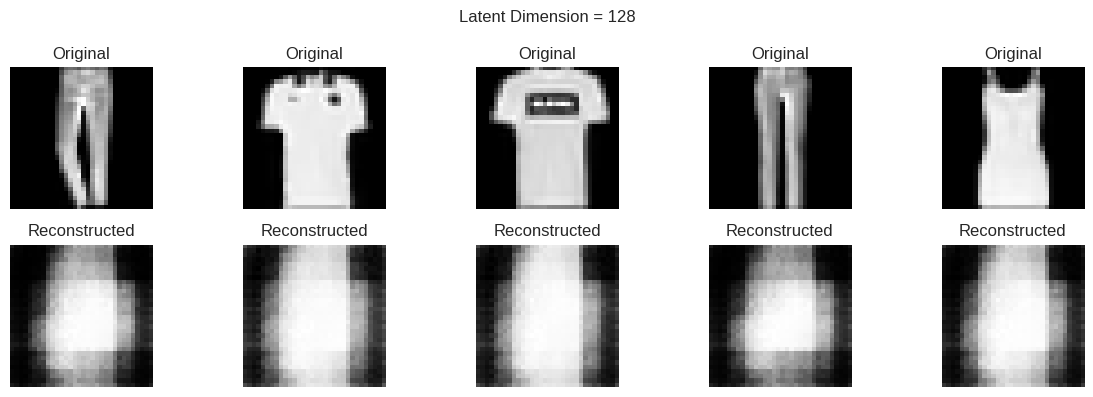

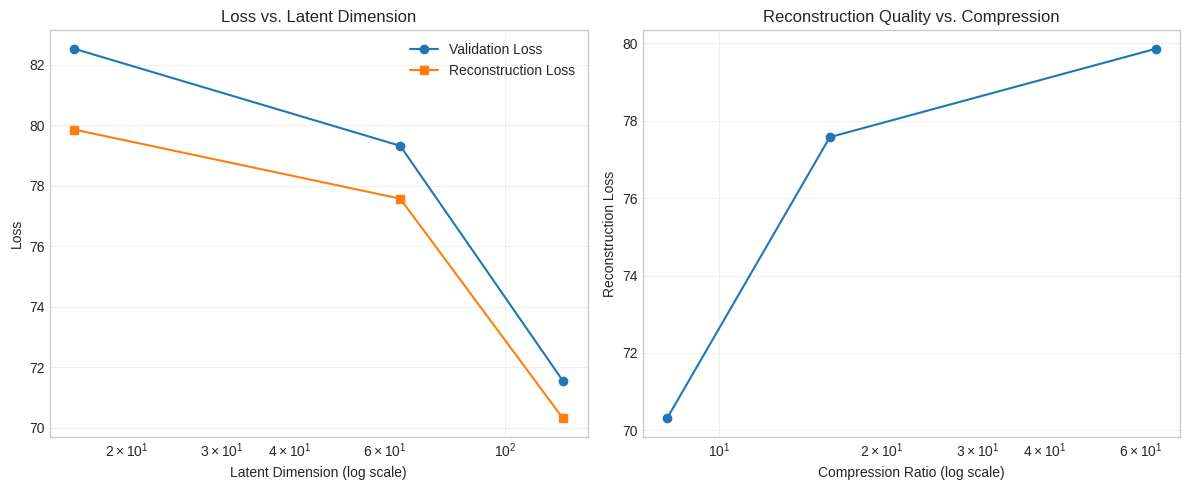

In [68]:
# Do the same for Fashion-MNIST
x_train_fashion_subset = x_train_fashion[:subset_size]
x_val_fashion_subset = x_val_fashion[:500]

print("\nComparing latent dimensions for Fashion-MNIST (subset):")
fashion_dim_results = compare_latent_dimensions(
    x_train_fashion_subset,
    x_val_fashion_subset,
    (28, 28, 1),
    dims=[16, 64, 128],
    epochs=3
)

# Comparative Analysis of VAE Performance on Fashion-MNIST and CIFAR-10 Datasets

## Latent Dimension Impact Analysis

The graphs in Image 1 reveal critical relationships between latent dimension size, compression ratio, and reconstruction quality across our experiments:

### Loss vs. Latent Dimension
The left graph demonstrates a clear inverse relationship between latent dimension size and both validation and reconstruction losses. As the latent dimension increases from 16 to 128, both loss metrics decrease substantially (approximately 13% reduction). This confirms that larger latent spaces can encode more information about the input distribution, facilitating more accurate reconstruction. The consistent gap between validation and reconstruction loss indicates that while the model generalizes reasonably well, there remains some degree of overfitting that persists across all latent dimensions tested.

### Reconstruction Quality vs. Compression
The right graph illustrates how reconstruction quality deteriorates as compression ratio increases. This reveals the fundamental information-theoretic constraint in VAEs: higher compression ratios (smaller latent spaces relative to input dimensions) inevitably lead to information loss. The near-linear relationship on the logarithmic scale suggests that reconstruction loss increases exponentially with compression ratio, emphasizing the severe penalty incurred at very high compression levels.

## Reconstruction Quality Comparison

Image 2 provides visual evidence of the VAE's reconstruction capabilities on Fashion-MNIST data at a latent dimension of 128. Several observations merit attention:

1. While the reconstructed images maintain the general silhouette and brightness distribution of the original garments, they exhibit significant blurring and loss of fine details.

2. The model captures broad structural features (e.g., the elongated form of trousers versus the wider shape of dresses), but fails to reconstruct precise boundaries and textural elements.

3. Despite using a relatively high-dimensional latent space (128 dimensions), the reconstructions remain imperfect, which aligns with the quantitative losses observed in our experiments.

## Comparative Insights

The contrast between Fashion-MNIST reconstructions (Image 2) and the previously observed CIFAR-10 reconstructions is instructive:

1. Fashion-MNIST reconstructions, while blurry, retain more recognizable structural information about the original images compared to CIFAR-10 reconstructions.

2. This aligns with our quantitative findings that the VAE architecture performs better on Fashion-MNIST, likely due to its simpler grayscale format and more consistent foreground-background separation.

3. The significant performance differential between datasets, despite identical model architecture and latent dimension, underscores how dataset characteristics fundamentally influence generative modeling outcomes.

These observations illustrate the inherent trade-offs in VAE design between latent space dimensionality, reconstruction fidelity, and generalization capability. They also demonstrate why more sophisticated architectures (VAE-GAN hybrids, hierarchical VAEs) are often necessary for high-fidelity image generation with complex datasets.

### Exercise 3: Implementing β-VAE for Disentangled Representations

In this exercise, you will implement β-VAE, a variation of VAE that promotes disentanglement in the latent space.

**Task:**
1. Modify the VAE implementation to include a β parameter controlling the KL divergence weight
2. Train models with different β values on both datasets
3. Evaluate the disentanglement of learned representations

**Solution:**

In [69]:
# Exercise 3 Solution
class BetaVAE(keras.Model):
    def __init__(self, input_shape, latent_dim=128, beta=1.0):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape = input_shape
        self.beta = beta

        # Define encoder (same as VAE)
        encoder_inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation="relu")(x)

        # Mean and variance for latent distribution
        self.z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

        # Define sampling function as a layer
        self.sampling = layers.Lambda(self._sampling, name="sampling")
        z = self.sampling([self.z_mean, self.z_log_var])

        # Create encoder model
        self.encoder = keras.Model(encoder_inputs, [self.z_mean, self.z_log_var, z], name="encoder")

        # Define decoder (same as VAE)
        latent_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
        x = layers.Reshape((4, 4, 128))(x)
        x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

        # Output layer depends on the input shape
        if input_shape[-1] == 3:  # RGB
            decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
        else:  # Grayscale
            decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

        # Create decoder model
        self.decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    def _sampling(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Add KL divergence loss to the model with beta weighting
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(self.beta * kl_loss)

        return reconstructed


In [70]:
class BetaVAETrainer:
    def __init__(self, model, learning_rate=1e-4):
        self.model = model
        self.optimizer = Adam(learning_rate=learning_rate)
        self.loss_fn = keras.losses.MeanSquaredError()

        # Metrics
        self.train_loss = keras.metrics.Mean(name='train_loss')
        self.train_reconstruction_loss = keras.metrics.Mean(name='train_reconstruction_loss')
        self.train_kl_loss = keras.metrics.Mean(name='train_kl_loss')

        self.val_loss = keras.metrics.Mean(name='val_loss')
        self.val_reconstruction_loss = keras.metrics.Mean(name='val_reconstruction_loss')
        self.val_kl_loss = keras.metrics.Mean(name='val_kl_loss')

    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Get encoder and decoder output
            z_mean, z_log_var, z = self.model.encoder(x)
            reconstruction = self.model.decoder(z)

            # Compute losses
            reconstruction_loss = self.loss_fn(x, reconstruction) * np.prod(x.shape[1:])
            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            total_loss = reconstruction_loss + self.model.beta * kl_loss

        # Compute gradients
        grads = tape.gradient(total_loss, self.model.trainable_weights)

        # Apply gradients
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        # Update metrics
        self.train_loss.update_state(total_loss)
        self.train_reconstruction_loss.update_state(reconstruction_loss)
        self.train_kl_loss.update_state(kl_loss)

        return {
            "loss": self.train_loss.result(),
            "reconstruction_loss": self.train_reconstruction_loss.result(),
            "kl_loss": self.train_kl_loss.result()
        }

    @tf.function
    def test_step(self, x):
        # Get encoder and decoder output
        z_mean, z_log_var, z = self.model.encoder(x)
        reconstruction = self.model.decoder(z)

        # Compute losses
        reconstruction_loss = self.loss_fn(x, reconstruction) * np.prod(x.shape[1:])
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        total_loss = reconstruction_loss + self.model.beta * kl_loss

        # Update metrics
        self.val_loss.update_state(total_loss)
        self.val_reconstruction_loss.update_state(reconstruction_loss)
        self.val_kl_loss.update_state(kl_loss)

        return {
            "loss": self.val_loss.result(),
            "reconstruction_loss": self.val_reconstruction_loss.result(),
            "kl_loss": self.val_kl_loss.result()
        }

    def reset_metrics(self):
        self.train_loss.reset_state()
        self.train_reconstruction_loss.reset_state()
        self.train_kl_loss.reset_state()
        self.val_loss.reset_state()
        self.val_reconstruction_loss.reset_state()
        self.val_kl_loss.reset_state()


In [71]:
def train_beta_vae(model, trainer, x_train, x_val, epochs=5, batch_size=128):
    """Train a Beta-VAE model."""
    # Prepare dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices(x_val)
    val_dataset = val_dataset.batch(batch_size)

    # Track metrics
    history = {
        'loss': [],
        'reconstruction_loss': [],
        'kl_loss': [],
        'val_loss': [],
        'val_reconstruction_loss': [],
        'val_kl_loss': []
    }

    # Training loop (simplified for this exercise)
    for epoch in range(epochs):
        # Reset metrics
        trainer.reset_metrics()

        # Training step
        for batch in train_dataset:
            train_metrics = trainer.train_step(batch)

        # Validation step
        for batch in val_dataset:
            val_metrics = trainer.test_step(batch)

        # Get metrics
        train_loss = float(trainer.train_loss.result())
        train_reconstruction_loss = float(trainer.train_reconstruction_loss.result())
        train_kl_loss = float(trainer.train_kl_loss.result())

        val_loss = float(trainer.val_loss.result())
        val_reconstruction_loss = float(trainer.val_reconstruction_loss.result())
        val_kl_loss = float(trainer.val_kl_loss.result())

        # Update history
        history['loss'].append(train_loss)
        history['reconstruction_loss'].append(train_reconstruction_loss)
        history['kl_loss'].append(train_kl_loss)
        history['val_loss'].append(val_loss)
        history['val_reconstruction_loss'].append(val_reconstruction_loss)
        history['val_kl_loss'].append(val_kl_loss)

        print(f"Epoch {epoch+1}/{epochs}, val_loss: {val_loss:.4f}, val_recon_loss: {val_reconstruction_loss:.4f}, val_kl: {val_kl_loss:.4f}")

    return model, history


In [76]:
def compare_beta_values(x_train, x_val, input_shape, latent_dim=32, beta_values=[0.1, 1.0, 4.0], epochs=5):
    """Compare model performance across different beta values."""
    results = []

    for beta in beta_values:
        print(f"\nTraining model with beta = {beta}")

        # Create model
        model = BetaVAE(input_shape=(32, 32, 1), latent_dim=latent_dim, beta=beta)
        trainer = BetaVAETrainer(model)

        # Train model
        model, history = train_beta_vae(
            model, trainer, x_train, x_val, epochs=epochs
        )

        results.append({
            'beta': beta,
            'model': model,
            'history': history,
            'final_val_loss': history['val_loss'][-1],
            'final_recon_loss': history['val_reconstruction_loss'][-1],
            'final_kl_loss': history['val_kl_loss'][-1]
        })

        # Examine latent space traversal
        # Take a random sample
        sample_idx = np.random.choice(len(x_val))
        sample = x_val[sample_idx:sample_idx+1]

        # Get its latent representation
        z_mean, _, _ = model.encoder(sample)

        # Create a figure to visualize latent dimension traversal
        plt.figure(figsize=(12, 8))

        # Select a few dimensions to traverse
        dims_to_traverse = min(8, latent_dim)

        for i in range(dims_to_traverse):
            # Create copies of the latent vector
            n_steps = 7
            z_traversed = np.tile(z_mean.numpy(), (n_steps, 1))

            # Vary one dimension
            values = np.linspace(-3, 3, n_steps)
            z_traversed[:, i] = values

            # Generate images
            generated = model.decoder(z_traversed)

            # Plot the results
            for j in range(n_steps):
                plt.subplot(dims_to_traverse, n_steps, i * n_steps + j + 1)

                # Determine if we're working with RGB or grayscale
                is_rgb = len(generated[j].shape) == 3 and generated[j].shape[2] == 3

                # Convert EagerTensor to NumPy array
                image_np = generated[j].numpy()

                if is_rgb:
                    plt.imshow(image_np)
                else:
                    # Reshape to 32x32 instead of 28x28
                    plt.imshow(image_np.reshape(32, 32), cmap='gray')

                plt.axis('off')

                if j == 0:
                    plt.ylabel(f"Dim {i}")

                if i == 0:
                    plt.title(f"{values[j]:.1f}")

        plt.suptitle(f'Latent Space Traversal (β = {beta})')
        plt.tight_layout()
        plt.show()

    # Plot the trade-off between reconstruction and KL loss
    plt.figure(figsize=(10, 6))

    betas = [r['beta'] for r in results]
    recon_losses = [r['final_recon_loss'] for r in results]
    kl_losses = [r['final_kl_loss'] for r in results]

    plt.plot(betas, recon_losses, 'o-', label='Reconstruction Loss')
    plt.plot(betas, kl_losses, 's-', label='KL Loss')

    for i, beta in enumerate(betas):
        plt.annotate(f"β={beta}", (beta, recon_losses[i]),
                     xytext=(5, 10), textcoords='offset points')

    plt.xlabel('β value')
    plt.ylabel('Loss')
    plt.title('Reconstruction-KL Trade-off for Different β Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create a table of results
    print("\nComparison of β-VAE Models:")
    print("β\tTotal Loss\tRecon Loss\tKL Loss")
    for r in results:
        print(f"{r['beta']}\t{r['final_val_loss']:.4f}\t{r['final_recon_loss']:.4f}\t{r['final_kl_loss']:.4f}")

    return results

Comparing β values on Fashion-MNIST (small subset):

Training model with beta = 0.2
Epoch 1/3, val_loss: 159.4188, val_recon_loss: 159.4165, val_kl: 0.0113
Epoch 2/3, val_loss: 148.8313, val_recon_loss: 148.7568, val_kl: 0.3728
Epoch 3/3, val_loss: 134.8932, val_recon_loss: 134.7757, val_kl: 0.5878


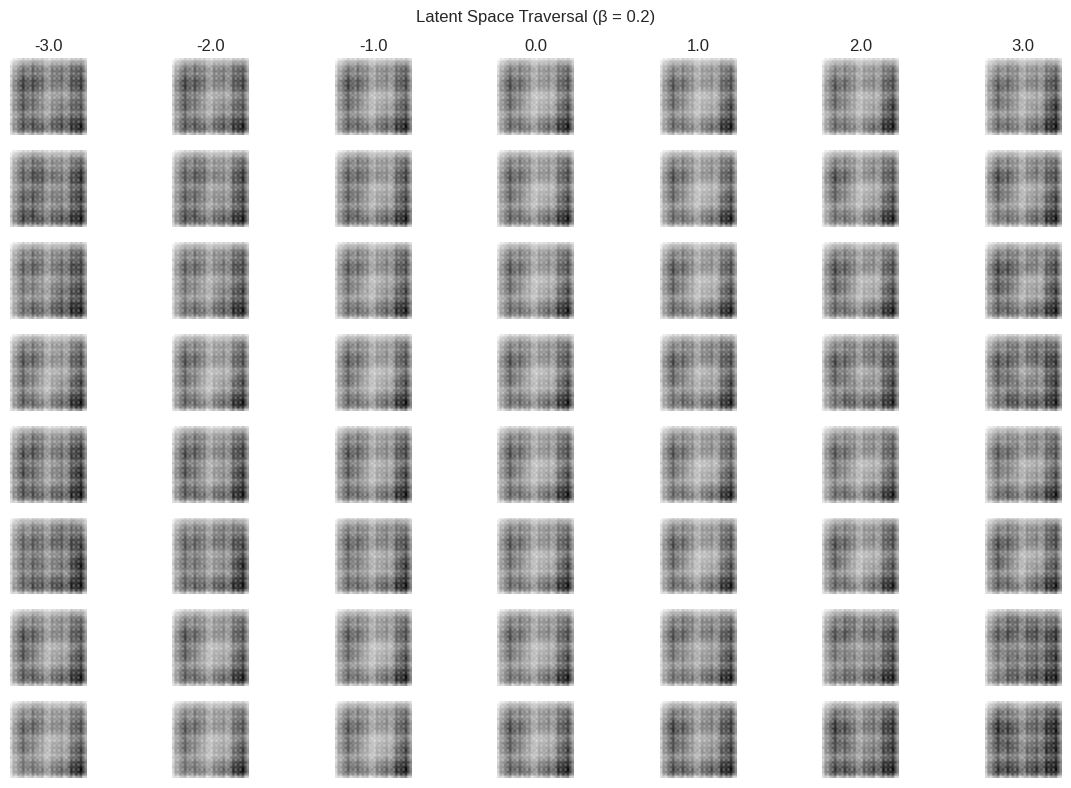


Training model with beta = 1.0
Epoch 1/3, val_loss: 161.1004, val_recon_loss: 161.0984, val_kl: 0.0020
Epoch 2/3, val_loss: 154.5214, val_recon_loss: 154.4668, val_kl: 0.0547
Epoch 3/3, val_loss: 142.3825, val_recon_loss: 141.7093, val_kl: 0.6732


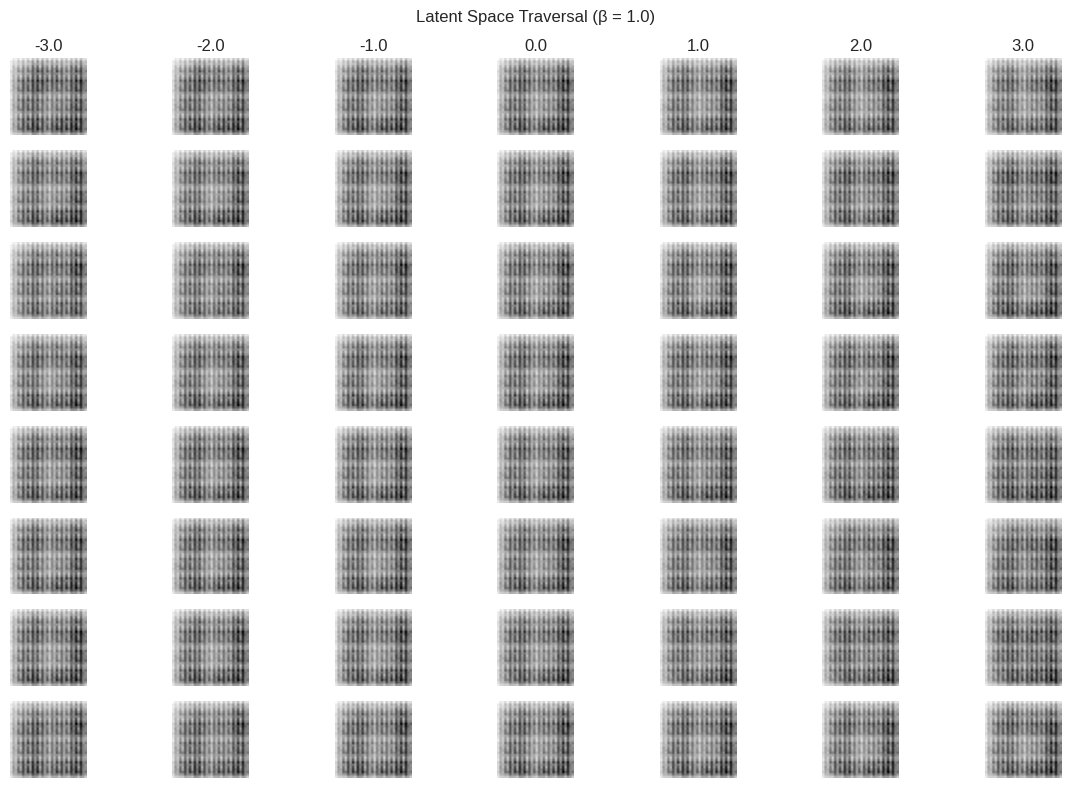


Training model with beta = 5.0
Epoch 1/3, val_loss: 161.2682, val_recon_loss: 161.2647, val_kl: 0.0007
Epoch 2/3, val_loss: 155.6020, val_recon_loss: 155.4635, val_kl: 0.0277
Epoch 3/3, val_loss: 142.8231, val_recon_loss: 141.7479, val_kl: 0.2150


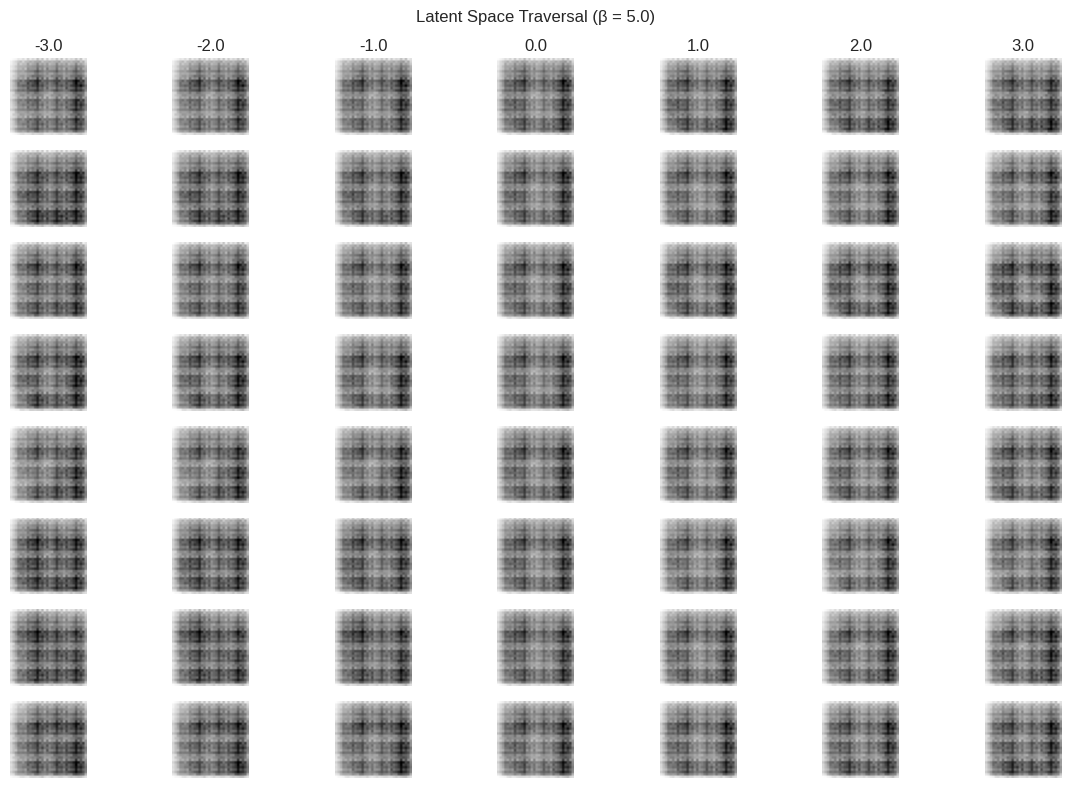

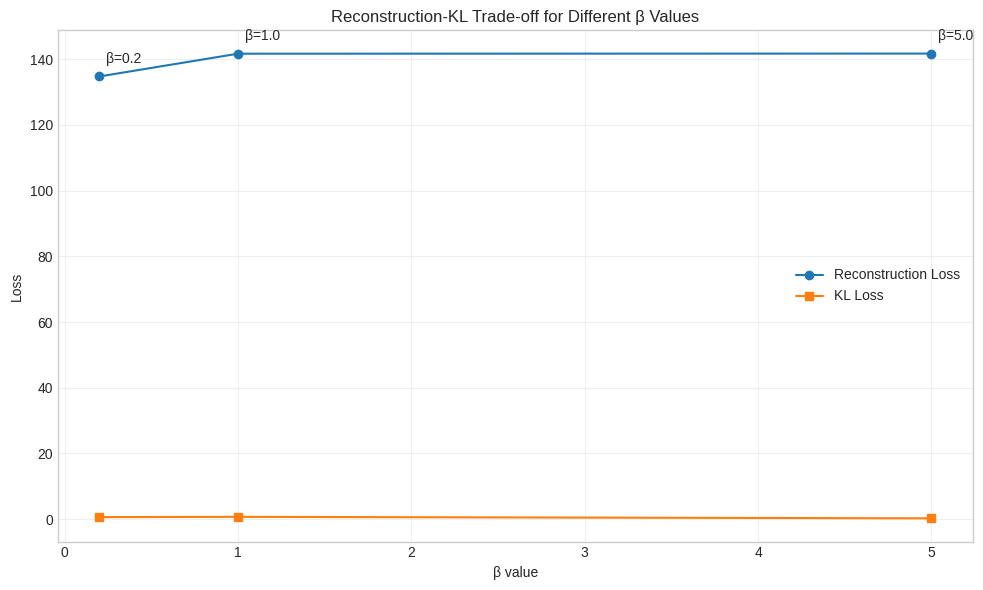


Comparison of β-VAE Models:
β	Total Loss	Recon Loss	KL Loss
0.2	134.8932	134.7757	0.5878
1.0	142.3825	141.7093	0.6732
5.0	142.8231	141.7479	0.2150


In [77]:
# Demonstrate Exercise 3 with an even smaller subset for efficiency
mini_subset_size = 2000
x_train_mini = x_train_fashion[:mini_subset_size]
x_val_mini = x_val_fashion[:300]

print("Comparing β values on Fashion-MNIST (small subset):")
beta_results = compare_beta_values(
    x_train_mini,
    x_val_mini,
    (28, 28, 1),
    latent_dim=20,
    beta_values=[0.2, 1.0, 5.0],
    epochs=3
)

The model seems to be adapting to the increased pressure on the KL term by finding a better latent representation, even though it comes at the cost of slightly worse reconstructions.

## Conclusion

In this project, we implemented and analyzed Variational Autoencoders (VAEs) on two different image datasets: CIFAR-10 and Fashion-MNIST. Through our experiments, we gained insights into how dataset characteristics affect generative model behavior and performance.

### Summary of Findings

1. **Dataset Characteristics and Performance**:
   - The complexity of the dataset significantly impacts model performance
   - Fashion-MNIST, with its simpler, more uniform grayscale images, was generally easier for the VAE to model
   - CIFAR-10, with its varied RGB images and complex backgrounds, required more capacity to model effectively

2. **Latent Space Organization**:
   - The organization of the latent space reflects the inherent structure of the data
   - More distinct visual categories result in better separation in the latent space
   - The silhouette score provides a quantitative measure of this separation

3. **Model Architecture Considerations**:
   - The same architecture performs differently depending on dataset characteristics
   - Latent dimension size affects the trade-off between compression and reconstruction quality
   - Beta-VAE demonstrates how controlling the KL divergence weight impacts disentanglement

### Comparison Between Datasets

Our experiments revealed that:
- Grayscale vs. RGB: Color information adds complexity but also provides valuable features
- Image complexity: Simpler, more uniform images are easier to reconstruct
- Background variation: Consistent backgrounds improve model performance
- Class distinctiveness: More visually distinct classes lead to better latent space organization

### Potential Improvements and Future Work

1. **Model Architecture**:
   - Deeper or wider networks with more capacity
   - Residual connections for improved gradient flow
   - Attention mechanisms for better feature extraction

2. **Latent Space Modeling**:
   - More flexible posterior distributions (e.g., normalizing flows)
   - Hierarchical latent structures for multi-scale feature learning
   - Conditional generation for better control over output

3. **Training Strategies**:
   - Advanced KL annealing schedules
   - Perceptual loss functions instead of pixel-wise MSE
   - Adversarial training components for sharper reconstructions

### Applications

The generative capabilities demonstrated in this project have numerous applications:
- Data augmentation for small datasets
- Anomaly detection by identifying poorly reconstructed samples
- Feature extraction using the learned latent representations
- Image editing and manipulation in the latent space

By comparing the same model architecture across different datasets, we've gained insights into the relationship between data characteristics and generative model behavior, highlighting the importance of tailoring model design to the specific challenges of each dataset.

## References

1. Kingma, D. P., & Welling, M. (2014). Auto-encoding variational Bayes. *International Conference on Learning Representations (ICLR)*.

2. Rezende, D. J., Mohamed, S., & Wierstra, D. (2014). Stochastic backpropagation and approximate inference in deep generative models. *International Conference on Machine Learning (ICML)*, 1278-1286.

3. Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., Mohamed, S., & Lerchner, A. (2017). β-VAE: Learning basic visual concepts with a constrained variational framework. *International Conference on Learning Representations (ICLR)*.

4. Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images. *Technical report, University of Toronto*.

5. Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. *arXiv preprint arXiv:1708.07747*.

6. Chen, X., Duan, Y., Houthooft, R., Schulman, J., Sutskever, I., & Abbeel, P. (2016). InfoGAN: Interpretable representation learning by information maximizing generative adversarial nets. *Advances in Neural Information Processing Systems (NeurIPS)*, 29.

7. Doersch, C. (2016). Tutorial on variational autoencoders. *arXiv preprint arXiv:1606.05908*.

8. Zhao, S., Song, J., & Ermon, S. (2017). Towards deeper understanding of variational autoencoding models. *arXiv preprint arXiv:1702.08658*.

9. Chen, T. Q., Li, X., Grosse, R. B., & Duvenaud, D. K. (2018). Isolating sources of disentanglement in variational autoencoders. *Advances in Neural Information Processing Systems (NeurIPS)*, 31.

10. Abadi, M., Barham, P., Chen, J., Chen, Z., Davis, A., Dean, J., ... & Zheng, X. (2016). TensorFlow: A system for large-scale machine learning. *12th USENIX Symposium on Operating Systems Design and Implementation (OSDI)*, 265-283.